# Практическое задание 3 

# Классификация с использованием BERT  и Transfer learning

## курс "Математические методы анализа текстов"


### ФИО: Каратыщев Дмитрий Иванович

## Введение


В этом задании вы будете определять категории товара по данным из чеков, предоставленным в соревновании [Data Fusion Context](https://boosters.pro/championship/data_fusion/data).


Для этого задания вам понадобятся следующие библиотеки:
 - [Pytorch](https://pytorch.org/).
 - [Transformers](https://github.com/huggingface/transformers).
 - [Tokenizers](https://github.com/huggingface/tokenizers).

Данные лежат в архиве data.zip, в котором лежит файл `data.csv`, содержащий тексты и соответствующие им категории товаров. Все объекты поделены между train, test, val и unsupervised. Для unsupervised объектов категории товаров недоступны. 

Скачать данные можно здесь: [ссылка на google диск](https://drive.google.com/file/d/1AHs7qJYg2tc8zblGlT0Dpe50e6RW-gAW/view?usp=sharing)

In [1]:
import sys
sys.path.append('/kaggle/input/nlp-task2/')

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
import importlib.util
import os

# Путь к файлу с дефисом в имени
module_path = '/kaggle/input/nlp-task2/tests.py'

# Загрузим модуль динамически
spec = importlib.util.spec_from_file_location("tests", module_path)
tests = importlib.util.module_from_spec(spec)
sys.modules["tests"] = tests
spec.loader.exec_module(tests)

In [4]:
sys.modules['tests']

<module 'tests' from '/kaggle/input/nlp-task2/tests.py'>

## Часть 1. Подготовка данных (2 балла)

Классические методы NLP (например, как мы делали в первом и втором домашнем задании) преобразуют тексты в списки индексов следующим образом:
1. "Очистка текста" от плохих символов, приводим (или не приводим) текст к нижнему регистру.
2. Текст делится по пробелам на слова.
3. По полученной коллекции текстов строится словарь вида "слово -> индекс", редкие слова выбрасываются, стопслова иногда тоже
4. Побитый на слова текст превращается в список индексов с помощью этого словаря.

Для трансформеров схема выглядит немного по-другому — используются более продвинутые методы токенизации типа `wordpiece, bpe, sentencepiece`. Основное концептуальное отличие — текст делится не только на слова по пробелам, но и сами слова делятся на "подслова" (читай subwords). Это верно для BPE и wordpiece, а sentencepiece вообще не учитывает пробелы. Более подробно ознакомиться с этими методами токенизации можно в наших лекциях.

В данном задании предлагается использовать wordpiece токенизатор, который использовали в оригинальной статье про BERT. Построить его можно с помощью библиотеки `tokenizers`:
1. Считайте данные с помощью `pandas`
2. Используя метод `tokenizers.BertWordPieceTokenizer.train` и список сырых текстов постройте токенизатор. Используйте нижний регистр (lowercase), чистый текст (clean_text), без акцентов (strip_accents), размера словаря 30000 (vocab_size).
3. Сохраните построенный токенизатор (метод `tokenizer.save_model`) и создайте объект класса `transformers.BertTokenizerFast`, который работает быстрее стандартной реализации, но не позволяет её обучать.

**Важно:** нужно при обучении c помощью параметра `special_tokens` завести индексы для токенов `[PAD], [UNK], [CLS], [SEP], [MASK]`, которые понадобятся нам дальше для обучения и использования модели.

In [5]:
import pandas as pd

data = pd.read_csv('/kaggle/input/nlp-task2/task3_data.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3155764 entries, 0 to 3155763
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   text    object
 1   label   int64 
 2   split   object
dtypes: int64(1), object(2)
memory usage: 72.2+ MB


In [7]:
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizerFast

import os, shutil


class WordpieceTokenizer:

    def __init__(
            self, 
            vocab_path, 
            strip_accents=True, 
            clean_text=True, 
            lowercase=True
    ):
        """
            vocab_path: путь к словарю
            strip_accents: очистка текста от акцентов
            clean_text: просто чистка текста от непонятных символов
            lowercase: приведение текста к нижнему регистру
            
            Подгружает токенизатор с помощью BertTokenizerFast.
        """
        self._tokenizer = BertTokenizerFast(
            vocab_file=vocab_path,
            do_lower_case=lowercase,
            clean_text=clean_text,
            strip_accents=strip_accents
        )

    @classmethod
    def from_corpus(
            cls,
            corpus,
            corpus_save_path,
            tokenizer_save_path,
            tokenizer_name,
            vocab_size=30000,
            min_frequency=2,
            strip_accents=True,
            clean_text=True,
            lowercase=True
    ):
        """
            corpus: список текстов
            corpus_save_path: временный путь для сохранения текстов в текстовом файле
            tokenizer_save_path: путь для сохранения файлов токенизатора
            tokenizer_name: название токенизатора, влияет на названия файлов токенизатора
            vocab_size: размер словаря
            min_frequency: минимальная частота элемента в словаре
            strip_accents: очистка текста от акцентов
            clean_text: просто чистка текста от непонятных символов
            lowercase: приведение текста к нижнему регистру
            
            С помощью списка сырых текстов формирует токенизатор
        """
        os.makedirs(corpus_save_path, exist_ok=True)
        os.makedirs(tokenizer_save_path, exist_ok=True)
        corpus_file_name = os.path.join(corpus_save_path, 'corpus.txt')
        with open(corpus_file_name, "w", encoding="utf-8") as file:
            for text in corpus:
                file.write(text + "\n")
        tokenizer = BertWordPieceTokenizer(
            clean_text=clean_text,
            lowercase=lowercase,
            strip_accents=strip_accents
        )
        tokenizer.train(
            files=corpus_file_name,
            vocab_size=vocab_size,
            min_frequency=min_frequency,
        )
        tokenizer.save_model(tokenizer_save_path, tokenizer_name)
        vocab_path = os.path.join(tokenizer_save_path, f'{tokenizer_name}-vocab.txt')
        return cls(
            vocab_path,
            strip_accents,
            clean_text,
            lowercase
        )


    def __call__(self, text):
        """
            text: str. Сырой текст
            
            returns: list of ints. Список индексов
            
            C помощью метода .encode преобразует текст в индексы.
        """
        return self._tokenizer.encode(text, add_special_tokens=False)

    @property
    def cls_token_id(self):
        """
            returns: индекс CLS токена
        """
        return self._tokenizer.cls_token_id

    @property
    def pad_token_id(self):
        return self._tokenizer.pad_token_id

    @property
    def mask_token_id(self):
        return self._tokenizer.mask_token_id

    @property
    def sep_token_id(self):
        return self._tokenizer.sep_token_id

    def all_special_tokens(self):
        return [self.cls_token_id, self.pad_token_id, 
                self.mask_token_id, self.sep_token_id]

    @property
    def vocab_size(self):
        """
            returns: размер словаря
        """
        return self._tokenizer.vocab_size

Создайте токенизатор:

In [8]:
tokenizer = WordpieceTokenizer.from_corpus(
    corpus=data.text.to_list(),
    corpus_save_path='/kaggle/working/corpus_saved/',
    tokenizer_save_path='/kaggle/working/tokenizer_saved/',
    tokenizer_name='bert-wordpiece-tokenizer'
)

tests.test_tokenizer(tokenizer)




Correct.


In [9]:
tokenizer("Фантазёр. Ты меня называла!")

[3040, 16166, 139, 18, 3544, 17164, 1423, 6767, 252, 5]

Нам доступно довольно большое количество неразмеченных данных, которое можно использовать для предобучения модели. Мы рассмотрим две задачи предобучения:
1. **Masked Language Modeling** — задача из BERT. Выбираем 15% слов, из них 80% заменяем на токен [MASK], 10% меняем на другие случайные слова, 10% оставляем как есть. Эти 15% слов предсказываем моделью. Вспомним пример из оригинальной статьи:
    * Исходный текст: `my dog is hairy`
    * Выбираем случайным образом 15% токенов для задачи. Допустим, выбрали четвертый токен - `hairy`
    * В 80% случаев заменяем токен на `[MASK]`: `my dog is [MASK]`
    * В 10% случаев на другой случайный токен: `my dog is apple`
    * В 10% случаев оставляем неизменным: `my dog is hairy`
    
    
2. **Sentence Order Prediction** — задача из ALBERT. Делим текст на два сегмента, с вероятностью 50% меняет сегменты местами. Предсказываем, в правильном ли порядке находятся сегменты.
    * Текст: `the man went to the store. he bought a gallon of milk`
    * Токенизируем и делим его на два сегмента: `the man went to the store` и `he bought a gallon of milk`
    * C вероятностью 50% меняем их местами: `[CLS] he bought a gallon of milk [SEP] the man went to the store`
    * С вероятностью 50% оставляем на месте: `[CLS] the man went to the store [SEP] he bought a gallon of milk`
    * "Левому" сегменту соответствует нулевой индекс сегмента, "правому" - индекс 1

Большая часть логики предобучения реализуется при подготовке данных.

Реализуйте **PretrainDataset**, который токенизирует поданные сырые тексты и умеет возвращать для текста с конкретным индексом случайный сегмент длины, не большей чем `maxlen`. Логика для задачи **SOP** должна быть реализована в `__getitem__`: выбранный сегмент надо поделить на два равных сегмента, подбросить монетку, и с 50% вероятностью поменять сегменты местами. Нужно также добавить `[CLS]` и `[SEP]` токены.

**hint:** чтобы существенно ускорить обучение (не потеряв при этом в качестве), после токенизации отсортируйте датасет по длине текстов.
**hint:** токенизация датасета для предобучения занимает существенное время (5 минут), поэтому во время отладки стоит сделать её один раз и сохранить результат на диск

In [10]:
from tqdm import tqdm
import numpy as np
import random
from copy import deepcopy

import torch
from torch.utils.data import Dataset


class PretrainDataset(Dataset):
    
    def __init__(
            self, 
            corpus, 
            tokenizer, 
            minlen,
            maxlen,
            permute_prob=0.5, 
            verbose=False, 
            presort=False,
            ds=None
    ):
        """
            corpus: list of strings. Список сырых текстов
            tokenizer: токенизатор
            minlen: минимально допустимая длина текста
            permute_prob: вероятность, с которой два сегмента меняются местами (происходит swap)
            maxlen: максимальная длина текста
            verbose: вывод прогресса токенизации текстов с помощью tqdm
            presort: отсортировать датасет по длинам токенизированных текстов (т.е. ds[0] выдает самый короткий текст)
        """
        super().__init__()
        attrs = [corpus, tokenizer, minlen, maxlen, permute_prob, verbose, presort]
        attrs_names = ["_corpus", "_tokenizer", "_minlen", "_maxlen", 
                       "_permute_prob", "_verbose", "_presort"]
        for idx, name in enumerate(attrs_names):
            setattr(self, name, attrs[idx])

        self._ds = []

        if ds is not None:
            self._ds = deepcopy(ds)
        else:
            for text in tqdm(self._corpus, disable=(not verbose)):
                tokenized = self._tokenizer(text)
                if len(tokenized) >= self._minlen:
                    self._ds.append(tokenized)
    
            if presort:
                self._ds.sort(key=len)
        
    def __len__(self):
        return len(self._ds)
    
    @property
    def tokenizer(self):
        """
            returns: tokenizer. Нужно для тестов
        """
        return self._tokenizer
    
    def set_maxlen(self, maxlen):
        """
            maxlen: максимальная длина текста
            
            поставить новое максимальное значение длины
        """
        self._maxlen = maxlen

    def save_model(self):
        names = [attr for attr in dir(self)]
        state_dict = {name[1:]: getattr(self, name) for name in names}
        torch.save(state_dict, '/kaggle/working/pretrain_dataset.pth')

    @classmethod
    def from_pretrained(cls, state_dict):
        return cls(**state_dict)
        
    def __getitem__(self, idx):
        """
            returns: 
                input_ids - тензор с индексами, 
                token_type_ids - тензор с сегментными айдишниками (0 у левого сегмента, 1 у правого),
                permuted - был ли swap сегментов
        """
        input_ids = self._ds[idx][:(self._maxlen - 3)]
        left_segment = input_ids[:len(input_ids) // 2]
        right_segment = input_ids[len(input_ids) // 2:]
        cls = [self._tokenizer.cls_token_id]
        sep = [self._tokenizer.sep_token_id]
        permuted = bool(np.random.binomial(1, 0.5, 1)[0])

        left_v = 0
        right_v = 1
        if permuted:
            left_segment, right_segment = right_segment, left_segment
            left_v, right_v = right_v, left_v
            
        token_type_ids = torch.tensor([left_v] * (len(left_segment) + 2) + [right_v] * (len(right_segment) + 1), 
                                      dtype=torch.int64)
        input_ids = torch.tensor(cls + left_segment + sep + right_segment + sep, 
                                 dtype=torch.int64)
        
        return input_ids, token_type_ids, permuted

Длину текстов нужно ограничить снизу. Нет смысла рассматривать слишком короткие тексты (например, единичную длину), для которых задачи предобучения вообще не работают. Длинные тексты более эффективны для задач типа MLM, так как у модели больше контекста для предсказания и больше таргетов на один объект.

Разумный способ определить минимальную длину текстов для MLM  — подобрать такую минимальную длину, чтобы вероятность замаскировать хотя бы одно слово в тексте была больше заданного порога.

Т.е. если мы каждое слово маскируем с вероятностью 15%, какой длины должен быть текст, чтобы с вероятностью $\geqslant$ 50% было замаскировано хотя бы одно слово?

Используйте ответ на данный вопрос как минимальную допустимую длину текстов:

Имеем следущие условия: $n$ - длина текста, $p = 0.15$, $\xi \sim Bi(n, p)$. Нам нужно найти такое $n$, чтобы $\mathbb{P}(\xi \geq 1) \geq 0.5$.

В общем случае имеем $\mathbb{P}(\xi \leq k) = \begin{pmatrix} n \\ k \end{pmatrix} p^k (1 - p)^{n - k}$

Тогда $\mathbb{P}(\xi \geq 1) = 1 - \mathbb{P}(\xi < 1) = 1 - \mathbb{P}(\xi = 0) = 1 - (1 - p)^{n}$

То есть нам нужно такое $n$, что $1 - (1 - p)^n \geq 0.5 \iff (1 - p)^n \leq 0.5 \iff n \log_2(1 - p) \leq \log_2(0.5) \iff$

$\iff n \geq \dfrac{\log_2(0.5)}{\log_2(1 - p)} \iff n \geq -\dfrac{1}{\log_2(1 - p)}$

Получаем, что $n = \left\lceil -\dfrac{1}{\log_2(1 - p)} \right\rceil = 5$

In [11]:
minlen = 5

Создайте датасет (с произвольным разумным значением maxlen):

In [12]:
ds = PretrainDataset(
    corpus=data.text.to_list(), 
    tokenizer=tokenizer, 
    minlen=5,
    maxlen=512,
    permute_prob=0.5, 
    verbose=True, 
    presort=True
)

100%|██████████| 3155764/3155764 [03:52<00:00, 13594.41it/s]


In [13]:
tests.test_dataset(ds)

Correct.


Длину текстов нужно как-то ограничить сверху. Иначе, если встретится какой-то очень-очень длинный текст, он не поместится в видеопамять. Самый простой способ определить ограничение по длине  — после токенизации построить гистограмму длин (например, используя **sns.distplot**) и методом пристального взгляда определить разумное ограничение длины. Другой вариант  — взять большое значение квантили.

**Вопрос:** какая максимальная длина текста подходит для этого датасета?

**Ответ:** 27

In [14]:
lens = [item.shape[0] for item, _, _ in ds]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


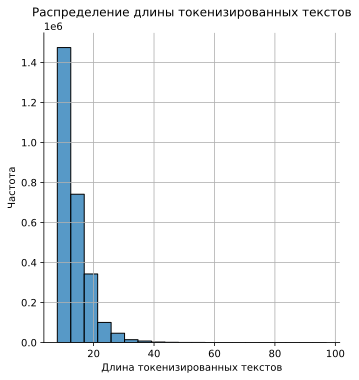

In [15]:
import seaborn as sns

sns.displot(lens, bins=20)
plt.xlabel('Длина токенизированных текстов')
plt.ylabel('Частота')
plt.title('Распределение длины токенизированных текстов')
plt.grid(True)
plt.show()

Присвойте максимально допустимое значение длины:

In [16]:
print(np.quantile(lens, [0.95, 0.97, 0.98]))

[23. 25. 27.]


In [17]:
ds.set_maxlen(27)

In [18]:
MAX_SEQLEN = 27

Если для задачи **SOP** мы готовим данные при индексации датасета `PretrainDataset`, то маскирование для задачи **MLM** удобней делать в Collator'е в тензорном виде.

Как с вероятностью `15%` заменить в тензоре `input_ids` значения на `0`: 

1. `mask = torch.rand(input_ids.shape) < 0.15`
2. `input_ids = torch.where(mask, 0, input_ids)`

Как сгенерировать случайные элементы словаря на каждый элемент батча: `torch.randint_like(input_ids, low=num_special_tokens, high=self._tokenizer.vocab_size)`.

В `Collator` нужно также:
1. сделать паддинг.
2. из (примерно) 15% выбранных токенов 10% поменять на случайные и 10% оставить в исходном виде, остальные замаскировать
3. сформировать таргеты. Нам нужно понимать, какие именно 15% токенов мы выбрали для предсказания + какие были исходные метки для них.

Важно: `[CLS]` и другие специальные токены токены маскировать не надо

In [19]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


class Collator:
    
    def __init__(
            self,
            tokenizer,
            non_target_idx=-100,
            mask_prob=0.15,
            random_prob=0.1,
            keep_unchanged_prob=0.1
    ):
        """
            tokenizer: токенизатор
            non_target_idx: значение для индексов, не использующихся как таргеты. 
                Используйте его, чтобы пометить "не таргет" токены
            mask_prob: вероятность выбрать индекс как таргет
            random_prob: вероятность для уже выбранного индекса поменять его на случайное значение вместо маскирования
            keen_unchanged_prob: вероятность оставить индекс в исходном виде вместо маскирования
        """
        names = ["_tokenizer", "_non_target_idx", "_mask_prob", "_random_prob", "_keep_unchanged_prob"]
        values = [tokenizer, non_target_idx, mask_prob, random_prob, keep_unchanged_prob]
        for name, value in zip(names, values):
            setattr(self, name, value)

    def pad_sequence_with_last_element(self, sequences, batch_first=False):
        """
        Дополняет список последовательностей последними элементами до длины самой длинной последовательности.
        
        Args:
            sequences (list of torch.Tensor): Список последовательностей, каждая из которых — это 1D тензор.
            batch_first (bool): Если True, возвращает тензор с размерностью (batch_size, max_len).
                                Если False, возвращает тензор с размерностью (max_len, batch_size).
        
        Returns:
            torch.Tensor: Батч дополненных последовательностей.
        """
        # Определяем длины всех последовательностей
        lengths = [seq.size(0) for seq in sequences]
        max_len = max(lengths)
    
        # Создаём пустой тензор для дополненных последовательностей
        padded_sequences = torch.zeros((len(sequences), max_len), dtype=sequences[0].dtype)
    
        for i, seq in enumerate(sequences):
            seq_len = seq.size(0)
            padded_sequences[i, :seq_len] = seq
            if seq_len < max_len:
                # Дополняем последовательность последним элементом
                padded_sequences[i, seq_len:] = seq[-1]
    
        if not batch_first:
            padded_sequences = padded_sequences.transpose(0, 1)
    
        return padded_sequences
        
    def __call__(self, batch):
        """
            batch: список вида [ds[i] for i in [12, 3, 2, 5]]
            
            returns: 
                input_ids: испорченные входные индексы токенов с замаскированными значениями
                token_type_ids: сегментные эмбеддинги
                labels: истинные значения входных индексов, как таргеты
                permuted: был ли свап сегментов
        """
        input_ids, token_type_ids, permuted = zip(*batch)

        input_ids = pad_sequence(input_ids, 
                                 batch_first=True, 
                                 padding_value=self._tokenizer.pad_token_id)
        token_type_ids = self.pad_sequence_with_last_element(token_type_ids, batch_first=True)

        target_mask = (torch.rand(input_ids.shape) < self._mask_prob).to(input_ids.device)
        labels = torch.zeros_like(input_ids, dtype=torch.int64)
        labels = torch.where(target_mask, input_ids, self._non_target_idx).to(input_ids.device)

        special_token_mask = torch.tensor([
            [1 if elem in self._tokenizer.all_special_tokens() else 0 for elem in item]
            for item in input_ids
        ], dtype=torch.bool, device=input_ids.device)

        target_mask &= ~special_token_mask

         # Генерация случайных замен
        random_tokens = torch.randint_like(
            input_ids, low=len(self._tokenizer.all_special_tokens()), high=self._tokenizer.vocab_size
        )

        # Маски для замены: 10% случайные токены, 10% оставить как есть, остальное маскировать
        random_mask = (torch.rand(input_ids.shape) < self._random_prob) & target_mask
        unchanged_mask = (torch.rand(input_ids.shape) < self._keep_unchanged_prob) & target_mask & ~random_mask
        mask_token = self._tokenizer.mask_token_id

        # Применение масок к input_ids
        input_ids = torch.where(random_mask, random_tokens, input_ids)
        input_ids = torch.where(target_mask & ~unchanged_mask & ~random_mask, mask_token, input_ids)
        
        return input_ids, token_type_ids, labels, torch.tensor(permuted, device=input_ids.device)

Создайте `collator` и `dataloader`. Для предобучения предлагается использовать большой `batch_size`.

In [20]:
collator = Collator(tokenizer, non_target_idx=-100)

dl = DataLoader(
    ds, 
    collate_fn=collator, 
    batch_size=256, 
    shuffle=False
)

In [21]:
tests.test_collator(ds, collator)

Correct.


## Часть 2. Создание модели (2 балла)

В качестве модели мы будем использовать энкодер трансформера точь-в-точь в таком же виде, как его использовали в оригинальной статье про BERT. 

Прежде чем начать писать составляющие энкодера, обсудим инициализацию весов. Для трансформера нам понадобится большое количество линейных слов (`nn.Linear`), у которых для инициализации по дефолту используется равномерное распределение и отсутствует зануление bias'ов: $$\text{Uniform} \left( -\frac{1}{ \sqrt{N_{\text{in\_features}}} }, \frac{1}{ \sqrt{N_{\text{in\_features}}} } \right)$$

В оригинальной статье про BERT для весов используется **TruncatedNormal** со стандартным отклонением 0.02, bias'ы инициализируются нулями и модель обучается значительно лучше (это можно в ходе домашнего задания проверить).

Поэтому, после создания линейных слоев и матрицы эмбеддингов, необходимо в явном виде вызывать для них TruncatedNormal инициализацию:

1. `layer = ...`
2. `nn.init.trunc_normal_(layer.weight.data, std=0.02, a=-2 * 0.02, b=2 * 0.02)`.

Для линейных слоев нужно также вызывать `layer.bias.data.zero_()`.


**TruncatedNormal** распределение отличается от нормального тем, что если величины выходят за границы отрезка [a, b], для этих величин повторно происходит сэмплирование до тех пор, пока они не попадут в нужный отрезок. Для BERT stddev = 0.02:

$$[a; b] = [- 2  \cdot \text{stddev}; 2 \cdot \text{stddev}].$$

Напишите функцию для инициализации линейных слоев и матрицы эмбеддингов **TruncatedNormal** распределением:

In [185]:
from torch import nn


def init_layer(layer, initializer_range=0.02, zero_out_bias=True):
    """
        layer: наследник nn.Module, т.е. слой в pytorch
        initializer_range: stddev для truncated normal
        zero_out_bias: True для линейных слоев, False для матрицы эмбеддингов
    """
    nn.init.trunc_normal_(layer.weight.data, 
                          std=initializer_range, 
                          a=-2 * initializer_range, 
                          b=2 * initializer_range)
    if zero_out_bias:
        layer.bias.data.zero_()

Приступим к созданию энкодера трансформера.
<img src="https://raw.githubusercontent.com/jserdyuk/mmp_NLP/refs/heads/main/Task2/images/transformer.png" />

Сформируем слой, создающий входные векторы токенов. Для этого нам нужны:
1. Эмбеддинги токенов (`nn.Embedding`)
2. Позиционные эмбеддинги (можно либо использовать `nn.Embedding`, либо явно создать матрицу эмбеддингов с помощью `nn.Parameter`)
3. Сегментные эмбеддинги

Эти три сущности складываются, затем идет layernorm и dropout.

<img src="https://raw.githubusercontent.com/jserdyuk/mmp_NLP/refs/heads/main/Task2/images/bert_input.png" />

In [186]:
class BertEmbeddings(nn.Module):
    
    def __init__(
            self, 
            vocab_size, 
            hidden_size, 
            max_seqlen,
            dropout_prob=0., 
            type_vocab_size=2,
            eps=1e-3
    ):
        """
            vocab_size: размер словаря
            hidden_size: размерность эмбеддингов
            max_seqlen: количество позиционных эмбеддингов
            dropout_prob: вероятность дропаута в конце слоя
            type_vocab_size: количество сегментных эмбеддингов
            eps: eps для layernorm
        """
        super().__init__()
        self._token_embeddings = nn.Embedding(vocab_size, hidden_size)
        self._pos_embeddings = nn.Embedding(max_seqlen, hidden_size)
        self._segment_embeddings = nn.Embedding(type_vocab_size, hidden_size)
        names = ["_vocab_size", "_hidden_size", "_max_seqlen", 
                 "_dropout_prob", "_type_vocab_size", "_eps"]
        values = [vocab_size, hidden_size, max_seqlen, 
                 dropout_prob, type_vocab_size, eps]
        for name, value in zip(names, values):
            setattr(self, name, value)
        self.dropout = nn.Dropout(dropout_prob)
        self.layer_norm = nn.LayerNorm(hidden_size, eps)
        
    def get_token_embeddings(self):
        """
            returns: возвращает слой с матрицей эмбеддингов для токенов. Нужен для MLM головы
        """
        return self._token_embeddings
    
    def forward(self, input_ids, token_type_ids=None):
        """
            input_ids: тензор с индексами токенов
            token_type_ids: сегментные индексы
            
            returns: эмбеддинги токенов
        """
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, device=input_ids.device).unsqueeze(0)
        
        # Сегментные индексы по умолчанию - нули, если не переданы
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # Суммирование эмбеддингов
        token_embeddings = self._token_embeddings(input_ids)
        position_embeddings = self._pos_embeddings(position_ids)
        type_embeddings = self._segment_embeddings(token_type_ids)

        embeddings = token_embeddings + position_embeddings + type_embeddings
        embeddings = self.dropout(self.layer_norm(embeddings))
        
        return embeddings

In [187]:
tests.test_bert_embeddings(BertEmbeddings)

Correct. Amount of parameters is: 7746560.


Как выглядит одноголовый **SelfAttention**:

<img src="https://raw.githubusercontent.com/jserdyuk/mmp_NLP/refs/heads/main/Task2/images/attention.png" width="700" height="700"/>

Как выглядит многоголовый (multihead) **SelfAttention:**

<img src="https://raw.githubusercontent.com/jserdyuk/mmp_NLP/refs/heads/main/Task2/images/multihead.png" width="400" height="400"/>

Реализация **MultiHeadSelfAttention** — самая сложная часть энкодера. Дальше будет проще :)

1. Принимаем на вход посл-ть векторов для каждого объекта в батче, т.е. тензор размера `batch_size x seqlen x dim`
2. Получаем из исходных векторов векторы `query, key, value` с помощью линейного слоя. $W_q X, W_k X, W_v X$.
    * **Важно:** не нужно делать три отдельных линейных слоя. Сделайте один линейный слой в три раза шире, затем после его применения разделите результат на три части с помощью метода `.chunk`. $W_{qkv} X$.
3. Полученные query, key, value векторы делятся между "головами" аттеншна c помощью `.view`. Далее операции происходят для каждой головы отдельно.
4. Нужно посчитать скалярные произведения всех запросов (queries) со всеми ключами (keys): $QK^T$.
5. Заменить значения для паддинг токенов на очень маленькие (большие отрицательные), чтобы они не влияли на софтмакс:         
    `attention_scores = attention_mask * attention_scores + (1 - attention_mask) * -100000`

6. Применить Dropout аттеншн скоров, который  выкидывает из аттеншна токены целиком.
7. Поделить "аттеншны скоры" на корень из размерности векторов и взять софтмакс по ключам. Т.е. $\text{softmax}(\frac{QK^T}{\sqrt{d}}, \text{axis=1})$
8. Посчитать контекстные векторы запросов $\text{softmax}(\frac{QK^T}{\sqrt{d}}, \text{axis=1})V$.
9. Сконкатенировать контекстные векторы всех голов и применить линейный слой той же размерности и dropout.
10. Сложить со входом **MultiHeadSelfAttention** слоя, применить layernorm: $\text{layernorm}(x + \text{dropout}(f(x)))$.

**Про аттеншн маску:**
* В полном виде аттеншн маска имеет размерность `batch_size x seqlen x seqlen`
* У нас же если токен не паддинг, то его видят остальные токены, поэтому по сути вся информация содержится в матрице размера `batch_size x seqlen` с предикатом является ли токен паддингом
* Эту матрицу размера `batch_size x seqlen` можно привести к виду `batch_size x seqlen x seqlen` операцией вида `attention_mask[:, None] * torch.ones_like(attention_mask)[..., None]`

**Вопросы:**
1. Зачем нужно делить на корень из $d$ результаты скалярных произведений?
2. Почему одно большое умножение на матрицу лучше, чем три маленьких?
3. Что будет, если мы не будем заменять значения аттеншн скоров паддинг токенов на большие отрицательные значения?
4. Какая вычислительная сложность (количество умножений) у операции **MultiheadSelfAttention**?

**Ваши ответы напишите здесь:**
1. Это нужно, чтобы дисперсия выходов не изменялась. Скалярное произведение - это сумма из $d$ элементов, а в силу независимости слагаемых, дисперсия скалярного произведения будет равна $d$ дисперсий каждого слагаемого. Чтобы дисперсия не изменилась, нужно поделить скалярное произведение на $\sqrt{d}$
2. Разделение операции на три маленькие приводит к дополнительным шагам в памяти, так как данные приходится загружать и выгружать трижды на GPU, а это очень затратная операция. При одном большом умножении эти шаги выполняются за один проход. При этом умножение через одну матрицу реализовано более эффективно
3. Паддинг-токены не содержат значимой информации и не должны вносить вклад в вычисление внимания. Если этого не сделать, модель начнёт уделять внимание бессмысленным токенам, что ухудшит качество эмбеддингов.
4. $O(\text{seq\_len} \cdot \text{hidden\_size}^2 + \text{seq\_len}^2 \cdot \text{hidden\_size})$

In [188]:
import math


class MultiHeadSelfAttention(nn.Module):
    
    def __init__(
            self,
            hidden_size,
            num_attention_heads,
            attention_probs_dropout_prob=0.,
            dropout_prob=0.,
            eps=1e-3
    ):
        """
            hidden_size: размерность эмбеддингов
            num_attention_heads: количество голов аттеншна. Обычно выбирается как hidden_size / num_attention_heads = 64,
                т.е. размерность векторов у одной головы 64
            attention_probs_dropout_prob: вероятность дропаута для аттеншн скоров
            dropout_prob: вероятность дропаута в конце слоя (перед суммой со входами)
            eps: eps для layernorm
        """
        super().__init__()
        names = ["_hidden_size", "_num_attention_heads", "_attention_probs_dropout_prob",
                 "_dropout_prob", "_eps"]
        values = [hidden_size, num_attention_heads, attention_probs_dropout_prob,
                 dropout_prob, eps]
        for name, value in zip(names, values):
            setattr(self, name, value)

        self._projection_linear = nn.Linear(hidden_size, 3 * hidden_size)
        self._output_linear = nn.Linear(hidden_size, hidden_size)
        self._dropout_attention = nn.Dropout(self._attention_probs_dropout_prob)
        self._dropout = nn.Dropout(self._dropout_prob)
        self._layernorm = nn.LayerNorm(hidden_size, eps)
        
    @property
    def size_per_head(self):
        """
            returns: размерность векторов для одной головы
        """
        return self._hidden_size // self._num_attention_heads
    
    def forward(self, embeddings, attention_mask):
        """
            embeddings: входные эмбеддинги
            attention_mask: тензор из 0, 1 размерности batch_size x seqlen x seqlen
            
            returns: контекстные векторы
        """
        B, L, H = embeddings.shape
        h = self._num_attention_heads
        d_h = self.size_per_head
        Q, K, V = torch.chunk(self._projection_linear(embeddings), 3, dim=-1)
        Q, K, V = [tensor.view(B, L, h, d_h).permute(0, 2, 1, 3) for tensor in [Q, K, V]]  # B x h x L x d_h
        attention_scores = (Q @ K.transpose(2, 3)) / (self.size_per_head ** 0.5)
        attention_scores = self._dropout_attention(attention_mask.unsqueeze(1) * attention_scores + 
                                         (1 - attention_mask.unsqueeze(1)) * -100000)
        output = (torch.softmax(attention_scores, dim=1) @ V).permute(0, 2, 1, 3).reshape(B, L, H)
        output = self._dropout(self._output_linear(output))
        output = self._layernorm(embeddings + output)
        return output

In [189]:
tests.test_attention(MultiHeadSelfAttention)

Correct. Amount of parameters: 263680.


Реализовать **полносвязный слой** гораздо проще - $\text{layernorm}(\text{dropout}(W_2 f(W_1 x + b_1) + b_2) + x)$:
1. Линейный слой, расширяющий входные векторы до *intermediate_size*, который традиционно равен 4 * hidden_size, т.е. происходит расширение в четыре раза
2. Функция активации (больше вы их нигде в модели не увидите)
3. Линейный слой, сужающий векторы обратно до *hidden_size*
4. Dropout, сложение со входом полносвязного слоя, layernorm

**Вопросы:**
1. Что дает "расширение" первым линейным слоем? Нельзя ли делать линейный слой поменьше?
2. Какая вычислительная сложность (количество умножений) у операции?
3. Используются ли где-то еще в трансформере функции активации (если не считать softmax функцией активации)?

**Ваши ответы напишите здесь:**
1. Слишком маленький размер первого линейного слоя в feed-forward приводит к недоиспользованию потенциала self-attention механизмов, а также потере большого количества потенциальных признаков для токенов. Чем меньше размер слоя, тем меньше сложных зависимостей будет учитывать наш энкодер
2. $O(n \cdot \text{hidden\_size} \cdot \text{intermediate\_size})$, где $n$ - количество токенов
3. Больше нигде не используются. Следовательно, этот слой является основной нелинейности для энкодера. Единственно, можно отметить MLM голову, но она является "надстройкой" над энкодером

In [190]:
class FeedForward(nn.Module):
    
    def __init__(
            self, 
            hidden_size, 
            intermediate_size, 
            dropout_prob=0., 
            act_func='relu', 
            eps=1e-3
    ):
        """
            hidden_size: размерность эмбеддингов
            intermediate_size: размерность промежуточного слоя. Обычно 4 * hidden_size
            dropout_prob: вероятность дропаута перед суммой со входными представлениями
            act_func: функция активации. Должны быть доступны gelu, relu
            eps: eps для layernorm
        """
        super().__init__()
        names = ["_hidden_size", "_intermediate_size", "_dropout_prob", "_act_func", "_eps"]
        values = [hidden_size, intermediate_size, dropout_prob, act_func, eps]
        for name, value in zip(names, values):
            setattr(self, name, value)
        self._feedforward = nn.Sequential(
            nn.Linear(hidden_size, intermediate_size),
            nn.ReLU() if act_func == 'relu' else nn.GELU(),
            nn.Linear(intermediate_size, hidden_size),
            nn.Dropout(dropout_prob)
        )
        self._layernorm = nn.LayerNorm(hidden_size, eps)

        
    def forward(self, embeddings):
        """
            embeddings: входные эмбеддинги размерности batch_size x seqlen x hidden_size
            
            returns: преобразованные эмбеддинги той же размерности
        """
        return self._layernorm(self._feedforward(embeddings) + embeddings)

In [191]:
tests.test_feedforward(FeedForward)

Correct. Amount of parameters is: 526080.


Объединим **MultiHeadSelfAttention** и **Feedforward** в один блок энкодера. Они применяются последовательно:

In [192]:
class BertLayer(nn.Module):
    
    def __init__(
            self, 
            hidden_size, 
            intermediate_size, 
            num_attention_heads, 
            dropout_prob=0., 
            attention_probs_dropout_prob=0.,
            act_func='relu',
            eps=1e-3
    ):
        super().__init__()
        self._multihead_attention = MultiHeadSelfAttention(
            hidden_size=hidden_size,
            num_attention_heads=num_attention_heads,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            dropout_prob=dropout_prob,
            eps=eps
        )
        
        self._feedforward = FeedForward(
            hidden_size=hidden_size,
            intermediate_size=intermediate_size,
            act_func=act_func,
            eps=eps,
            dropout_prob=dropout_prob
        )
        
    def forward(self, x, attention_mask=None):
        x = self._multihead_attention(x, attention_mask)
        x = self._feedforward(x)
        return x

In [193]:
tests.test_bert_layer(BertLayer)

Correct. Amount of parameters is: 789760.


Объедините **BertEmbeddings** и произвольное заданное число **BertLayer** слоёв в один слой:

In [194]:
class Bert(nn.Module):
    
    def __init__(
            self, 
            vocab_size,
            max_seqlen,
            hidden_size,
            num_hidden_layers,
            intermediate_size, 
            num_attention_heads, 
            input_dropout_prob=0.,
            dropout_prob=0., 
            attention_probs_dropout_prob=0.,
            act_func='relu',
            eps=1e-3
    ):
        super().__init__()
        self._embeddings = BertEmbeddings(vocab_size, hidden_size, max_seqlen, 
                                          dropout_prob, eps=eps)
        self._bert = nn.ModuleList([
            BertLayer(hidden_size, intermediate_size, 
                      num_attention_heads, dropout_prob, 
                      attention_probs_dropout_prob, 
                      act_func, eps) 
            for _ in range(num_hidden_layers)
        ])
        
    def get_token_embeddings(self):
        """
            returns: эмбеддинги токенов (матрицу эмбеддингов)
        """
        return self._embeddings.get_token_embeddings()
    
    @staticmethod
    def expand_mask(attention_mask):
        """
            attention_mask: маска паддинга размерности batch_size x seqlen
            
            returns: маска паддинга размерности batch_size x seqlen x seqlen
        """
        return attention_mask[:, None] * torch.ones_like(attention_mask)[..., None]
    
    def forward(self, x, attention_mask=None, token_type_ids=None):
        embeddings = self._embeddings(x, token_type_ids)
        attention_mask = torch.ones(x.shape[0], x.shape[1]) if attention_mask is None else attention_mask
        for bert_layer in self._bert:
            x = bert_layer(embeddings, Bert.expand_mask(attention_mask))
        return x

In [195]:
tests.test_bert(Bert)

Correct. Amount of parameters is: 10905600.


Для предобучения (и для целевых задач) необходимо задать "головы" модели:

Голова для **MLM** задачи выглядит как $W_2 \text{layernorm} (f(W_1 x + b_1)) + b_2$:
1. Линейный слой $d \times d$
2. Функция активации
3. LayerNorm
4. Линейный слой $d \times |V|$, где $|V|$ --- размер словаря. **Важно:** в качестве матрицы, на которую происходит умножение при аффинном преобразовании, берется матрица эмбеддингов токенов.
5. Функционал ошибки тоже будем считать сразу в голове, для него используется **nn.CrossEntropyLoss**: 
    * `self._criterion(preds.view(-1, self._vocab_size), labels.view(-1))`

Чтобы использовать матрицу входных эмбеддингов вместо последнего линейного слоя в голове, можно использовать присваивание вида`self._decoder.weight = input_embeddings.weight`.

In [196]:
class MlmHead(nn.Module):

    def __init__(
            self, 
            hidden_size, 
            vocab_size, 
            hidden_act, 
            eps=1e-3, 
            ignore_index=-100, 
            input_embeddings=None
    ):
        """
            hidden_size: размерность эмбеддингов
            vocab_size: размер словаря
            hidden_act: функция активации
            eps: eps для layernorm
            ignore_index: индекс таргета, который необходимо игнорировать при подсчете лосса
            input_embeddings: слой с эмбеддингами токенов, для использования матрицы эмбеддингов вместо линейного слоя
        """
        super().__init__()
        self._mlm = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU() if hidden_act == "relu" else nn.GELU(),
            nn.LayerNorm(hidden_size, eps=eps),
            nn.Linear(hidden_size, vocab_size)
        )
        if input_embeddings is not None:
            self._mlm[-1].weight = input_embeddings.weight
        self._criterion = nn.CrossEntropyLoss()
        self._ignore_index = ignore_index
        self._vocab_size = vocab_size

    def forward(self, hidden_states, labels):
        """
            hidden_states: эмбеддинги токенов
            labels: истинные метки, т.е. изначальные индексы токенов
            
            returns: посчитанный лосс
        """
        preds = self._mlm(hidden_states)
        mask = labels.view(-1) != self._ignore_index
        return self._criterion(preds.view(-1, self._vocab_size)[mask], labels.view(-1)[mask])

In [197]:
tests.test_mlm_head(MlmHead, BertEmbeddings)

Correct. Amount of parameters is: 7776304.


Голова для **SOP**-задачи выглядит аналогично и в оригинальной статье называется "pooler-слоем":
1. Берем скрытое представление CLS токена
2. Линейный слой $d \times d$
3. Функция активации, причем в качестве функции активации используется гиперболический тангенс **nn.Tanh**
4. Dropout
5. Линейный слой
6. Функционал ошибки (бинарная кросс-энтропия с логитами, **nn.BCEWithLogitsLoss**)

Эту голову (кроме последнего линейного слоя) мы будем использовать также и для целевой задачи (классификации чеков).

In [198]:
class ClassifierHead(nn.Module):
    CLS_POSITION = 0
    CRITERION = nn.BCEWithLogitsLoss()
    
    def __init__(self, 
                 hidden_size, 
                 num_classes=1, 
                 hidden_dropout_prob=0.):
        """
            hidden_size: размерность эмбеддингов
            hidden_dropout_prob: вероятность дропаута
        """
        super().__init__()
        self._sop = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Dropout(hidden_dropout_prob),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, hidden_states, permuted=None):
        """
            hidden_states: эмбеддинги
            permuted: таргеты (были ли свапы сегментов). Если их нет, то необходимо выдать предсказания
        """
        cls_tokens = self._sop(hidden_states)[:, self.CLS_POSITION].squeeze()
        return cls_tokens if permuted is None else self.CRITERION(cls_tokens, permuted.squeeze().float())

In [199]:
tests.test_classifier_head(ClassifierHead)

Correct. Amount of parameters is: 66049.


Объединим **Bert**, **MlmHead** и **ClassifierHead** в единую модель:

In [200]:
class BertModel(nn.Module):

    def __init__(
            self, 
            hidden_size, 
            vocab_size,
            max_seqlen,
            num_hidden_layers,
            intermediate_size,
            num_attention_heads,
            act_func='relu',
            input_dropout_prob=0.,
            hidden_dropout_prob=0., 
            attention_probs_dropout_prob=0.,
            eps=1e-3, 
            ignore_index=-100
    ):
        super().__init__()
        self._backbone = Bert(
            vocab_size=vocab_size,
            max_seqlen=max_seqlen,
            hidden_size=hidden_size,
            num_hidden_layers=num_hidden_layers,
            intermediate_size=intermediate_size, 
            num_attention_heads=num_attention_heads, 
            input_dropout_prob=input_dropout_prob,
            dropout_prob=hidden_dropout_prob, 
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            act_func=act_func,
            eps=eps
        )
        self._mlm_head = MlmHead(
            hidden_size, 
            vocab_size, 
            act_func, 
            eps, 
            ignore_index, 
            input_embeddings=self._backbone.get_token_embeddings()
        )
        self._classifier_head = ClassifierHead(
            hidden_size, 
            hidden_dropout_prob=hidden_dropout_prob, 
            num_classes=1
        )

    def forward(self, x, attention_mask, labels, permuted, token_type_ids=None):
        hidden_states = self._backbone(x, attention_mask, token_type_ids)
        mlm_loss = self._mlm_head(hidden_states, labels)
        sop_loss = self._classifier_head(hidden_states, permuted)
        # в оригинальном BERT лоссы MLP и NSP используются с равными весами
        return 0.5 * mlm_loss + 0.5 * sop_loss, {'MLM': mlm_loss, 'SOP': sop_loss}

Значения гиперпараметров:
* для успешного выполнения задания достаточно архитектуры bert-mini: `hidden_size=256`, `num_hidden_layers=4`, в качестве функции активации можно использовать `gelu`
* стандартные практики: `intermediate_size = 4 * hidden_size`, `num_attention_heads = hidden_size // 64`
* в оригинальной статье везде dropout равен 0.1, но для bert-mini модели можно попробовать значения поменьше. Вопрос - почему?

In [201]:
model = BertModel(
    hidden_size=256, 
    vocab_size=30000,
    max_seqlen=MAX_SEQLEN,
    num_hidden_layers=4,
    intermediate_size=(4 * 256),
    num_attention_heads=(256 // 64),
    act_func='gelu',
    input_dropout_prob=0.05,
    hidden_dropout_prob=0.05, 
    attention_probs_dropout_prob=0.05,
    eps=1e-3, 
    ignore_index=-100
)

In [202]:
def count_parameters(model):
    paramcount_dict = dict()
    for name, param in model.named_parameters():
        if param.requires_grad:
            paramcount_dict[name] = param.numel()
    paramcount_dict = dict(sorted(paramcount_dict.items(), key=lambda item: item[1]))
    for name, param in paramcount_dict.items():
        print(f"Layer: {name} | Parameters: {param}")

count_parameters(model)

Layer: _classifier_head._sop.3.bias | Parameters: 1
Layer: _backbone._embeddings.layer_norm.weight | Parameters: 256
Layer: _backbone._embeddings.layer_norm.bias | Parameters: 256
Layer: _backbone._bert.0._multihead_attention._output_linear.bias | Parameters: 256
Layer: _backbone._bert.0._multihead_attention._layernorm.weight | Parameters: 256
Layer: _backbone._bert.0._multihead_attention._layernorm.bias | Parameters: 256
Layer: _backbone._bert.0._feedforward._feedforward.2.bias | Parameters: 256
Layer: _backbone._bert.0._feedforward._layernorm.weight | Parameters: 256
Layer: _backbone._bert.0._feedforward._layernorm.bias | Parameters: 256
Layer: _backbone._bert.1._multihead_attention._output_linear.bias | Parameters: 256
Layer: _backbone._bert.1._multihead_attention._layernorm.weight | Parameters: 256
Layer: _backbone._bert.1._multihead_attention._layernorm.bias | Parameters: 256
Layer: _backbone._bert.1._feedforward._feedforward.2.bias | Parameters: 256
Layer: _backbone._bert.1._feed

**Вопросы:**
1. Какая часть модели содержит наибольшее количество параметров? Эмбеддинги, аттеншн, полносвязные слои, голова?
2. Зачем объединять параметры в голове и параметры матрицы эмбеддингов?

**Ваши ответы напишите здесь:**
1. Легко видеть, что больше всего параметров имеет слой Эмбеддингов - 7,680,000 параметров. Дальше идёт FeedForward слой, а потом MLM по количеству параметров.
2. Матрица эмбеддингов используется для кодирования токенов и может быть повторно использована для декодирования токенов. Если выходная голова обучается независимо, это приводит к дублированию параметров. Также важно отметить, что BERT реализует метод weight tying. Этот метод снижает риск рассогласования между входными и выходными пространствами токенов.

## Часть 3. Оптимизация (1 балл)

Для оптимизации будем использовать **AdamW**, отличия которого от ванильного **Adam** можно почитать, например, [вот здесь](https://towardsdatascience.com/why-adamw-matters-736223f31b5d)

Параметры модели, передаваемые в оптимизатор, следует поделить на две группы с помощью `model.named_parameters()`:
1. Все `bias` и `layernorm` слои, присутствующие в модели (их можно выцепить по названию). Для них $l_2$ регуляризацию стоит выключить, т.е. поставить `weight_decay=0`
2. Оставшиеся слои, для которых регуляризация не нужна.


**Вопрос:** почему $l_2$ регуляризацию не используют для bias'ов? Для layernorm?
**Ответ:** регуляризация bias'ов может ухудшить способность модели компенсировать смещения в данных. Они мало влияют на переобучение. Параметры в layernorm нормализуют значения перед переходом на следующие слои. Сам по себе слой позволяет плавно обучать модель. Регуляризация параметров в layernorm может испортить нормализацию слоёв, что ухудшит обучение. 

In [203]:
def get_optimizer(model, weight_decay=0.01):
    """
        model: инициализированная модель
        weight_decay: коэффициент l2 регуляризации
        
        returns: оптимизатор
    """
    decayed_parameters, not_decayed_parameters = [], []
    for name, param in model.named_parameters():
        if "layernorm" in name or name.endswith("bias"):
            not_decayed_parameters.append(param)
        else:
            decayed_parameters.append(param)
            
    grouped_parameters = [
        {'params': decayed_parameters, 'weight_decay': weight_decay},
        {'params': not_decayed_parameters, 'weight_decay': 0.}
    ]

    return torch.optim.AdamW(grouped_parameters)

In [204]:
optimizer = get_optimizer(model, weight_decay=1e-2)

In [205]:
tests.test_optimizer(get_optimizer, model)

Correct.


Как выглядит типичное расписание lr для трансформеров:
<img src="https://raw.githubusercontent.com/jserdyuk/mmp_NLP/refs/heads/main/Task2/images/lr.png" width="500" height="500"/>

Почему мы сразу не стартуем с большого значения lr? Для больших архитектур трансформера модель разойдется, произойдет взрыв градиентов. Постепенно же увеличить lr до большого значения — можно. Процедуру линейного увеличения lr до какого-то пикового значения называют `linear warmup`.

Реализуйте такое "треугольное" расписание для learning rate в предложенном шаблоне.

**Вопрос:** а зачем нужно убывание learning rate?

Чем ближе мы подходим к локальным экстремумам определённого функционала, тем меньшие шаги нужно делать, чтобы эти экстремумы не перескочить. Если оставлять learning rate постоянным, то модель может легко перескочить через необходимый локальный минимум, ибо градиентный шаг будет слишком большим. Если же уменьшать градиентный шаг, то в силу непрерывной аппроксимации функционалов эмпирического риска малые изменения параметров будут влечь за собой малые изменения функционала, что поможет аккуратнее подходить к локальным экстремумам.

In [206]:
class Scheduler:
    
    def __init__(
            self, 
            optimizer, 
            init_lr, 
            peak_lr, 
            final_lr, 
            num_warmup_steps, 
            num_training_steps
    ):
        """
            optimizer: оптимизатор
            init_lr: начальное значение learning rate
            peak_lr: пиковое значение learning rate
            final_lr: финальное значение lr
            num_warmup_steps: количество шагов разогрева (сколько шагов идем от начального до пикового значения)
            num_training_steps: количество шагов обучения (количество батчей x количество эпох)
            
        """
        self._step = 0
        names = ["_optimizer", "_init_lr", "_peak_lr", "_final_lr", "_num_warmup_steps", "_num_training_steps"]
        values = [optimizer, init_lr, peak_lr, final_lr, num_warmup_steps, num_training_steps]
        for name, value in zip(names, values):
            setattr(self, name, value)
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = self._init_lr
        
    def step(self):
        """
            Меняет learning rate для оптимизатора
            
            Поменять learning rate для группы параметров в оптимизаторе можно присваиванием вида param_group['lr'] = lr
        """
        if self._step < self._num_warmup_steps:
            add_lr = (self._peak_lr - self._init_lr) / self._num_warmup_steps
        elif self._step < self._num_training_steps:
            add_lr = (self._final_lr - self._peak_lr) / (self._num_training_steps - self._num_warmup_steps)
        else:
            add_lr = 0
        
        for param_group in self._optimizer.param_groups:
            param_group['lr'] += add_lr
            
        self._step += 1
        
    def get_last_lr(self):
        """
            returns: текущий learning rate оптимизатора. Нужно для логгирования
        """
        return [param_group['lr'] for param_group in self._optimizer.param_groups]

In [207]:
tests.test_scheduler(Scheduler, get_optimizer, model)

Correct.


In [208]:
print(len(dl))

10670


In [209]:
N_EPOCHS_PRETRAINED = 2

In [210]:
scheduler = Scheduler(
    optimizer=optimizer, 
    init_lr=3e-6, 
    peak_lr=2e-4, 
    final_lr=0, 
    num_warmup_steps=int(0.1 * len(dl) * N_EPOCHS_PRETRAINED), 
    num_training_steps=(len(dl) * N_EPOCHS_PRETRAINED)
)

От запуска обучения нас отделяет только создание `Trainer`. От объектов класса `Trainer` требуется, чтобы:
* логгировался лосс на каждом батче (`torch.utils.tensorboard.SummaryWriter`, `writer.add_scalar`)
* клипались и логгировались нормы градиентов при каждом шаге спуска (`orch.nn.utils.clip_grad_norm_` возвращает нормы градиентов)
* логгировались значения learning rate
* была поддержана аккумуляция градиентов, нужная для эмуляции больших батчей

При предобучении не нужно использовать какую-либо форму валидации, достаточно смотреть на батч лосс.

Предлагается также для ускорения обучения использовать mixed precision из библиотеки `apex`:
* перед обучением необходимо вызвать строчку вида `model, optimizer = amp.initialize(model, optimizer, opt_level='O1')`
* при обучении `.backward()` надо делать в контекстном менеджере:     
   `with amp.scale_loss(loss, optimizer) as scaled_loss: scaled_loss.backward()`
        
Что такое аккумуляция градиентов:
* При использовании Adam в видеопамяти необходимо хранить градиенты и квадраты частных производных
* При подсчете градиента по очередному батчу необязательно сразу делать шаг спуска, можно запомнить градиент, а затем посчитать градиент по другому батчу c теми же параметрами модели
* Теперь эти два градиента можно сложить и получить градиент, который был посчитан как будто по одному большому батчу (составленному из этих двух). Сэмулировали большой батч. В данном случае количество шагов аккумуляции равно двум.
* В данном случае количество шагов аккумуляции равно двум.

Зачем нужны большие батчи? Обучение быстрее, оценки градиента точнее, позволяет увеличивать learning rate. Например, при предобучении авторы RoBERTA значительно увеличили размер батча по сравнению с ванильным BERT и получили прирост к качеству решения целевых задач.

In [211]:
import os
import shutil
from collections import defaultdict
from tqdm.notebook import tqdm
from torch.nn.utils import clip_grad_norm_
from time import time

# from apex import amp
from torch.cuda.amp import autocast, GradScaler

import torch
from torch.utils.tensorboard import SummaryWriter


class Trainer:

    def __init__(
            self, 
            model, 
            optimizer, 
            scheduler,
            pad_token_id,
            device,
            num_accum_steps=1,
            logdir=None,
            max_grad_norm=None
    ):
        """
            model: объект класса BertModel
            optimizer: оптимизатор
            scheduler: расписание learning rate. Нужно вызывать scheduler.step() ПОСЛЕ optimizer.step()
            pad_token_id: индекс паддинга. Нужен для создания attention mask
            device: девайс (cpu или cuda), на котором надо производить вычисления
            num_accum_steps: количество шагов аккумуляции
            logdir: директория для записи логов
            max_grad_norm: максимум нормы градиентов, для клиппинга
        """
        names = ["_model", "_optimizer", "_scheduler", 
                 "_pad_token_id", "_device", "_num_accum_steps", 
                 "_logdir", "_max_grad_norm", "_writer", 
                 "_n_epoch", "_scaler", "_verbose_step"]
        values = [model.to(device), optimizer, scheduler, 
                  pad_token_id, device, num_accum_steps, 
                  logdir, max_grad_norm, SummaryWriter(logdir) if logdir else None, 
                  0, torch.amp.GradScaler("cuda"), 100]
        
        for name, value in zip(names, values):
            setattr(self, name, value)

    def train(self, dataloader, n_epochs):
        print(f"STEPS: {n_epochs * len(dataloader)}", end='\n')
        for epoch in range(n_epochs):
            start_time = time()
            self._train_step(dataloader)
            end_time = time() - start_time
            print(f"\nTRAIN TIME: {end_time:.4f}\n")
            self._n_epoch += 1

    def _batch_to_device(self, batch):
        batch = list(batch)
        for i in range(len(batch)):
            batch[i] = batch[i].to(self._device)
        return batch

    def _train_step(self, dataloader):
        """
            dataloader: объект класса DataLoader для обучения
        """
        total_loss = 0.0
        self._optimizer.zero_grad()
        for step, batch in tqdm(enumerate(dataloader)):
            input_ids, token_type_ids, labels, permuted = self._batch_to_device(batch)
            attention_mask = (input_ids != self._pad_token_id).int()

            # Используем mixed precision
            with torch.amp.autocast("cuda"):
                loss, _ = self._model(input_ids, attention_mask, labels, 
                                      permuted.int(), token_type_ids=token_type_ids)
                loss = loss / self._num_accum_steps

            # Backward с помощью scaler
            self._scaler.scale(loss).backward()

            if (step + 1) % self._num_accum_steps == 0 or (step + 1) == len(dataloader):
                if self._max_grad_norm is not None:
                    # Клиппинг градиентов
                    self._scaler.unscale_(self._optimizer)  # Убираем скалирование перед клиппингом
                    grad_norm = clip_grad_norm_(self._model.parameters(), self._max_grad_norm)
                else:
                    grad_norm = None

                # Шаг оптимизатора и обновление scaler
                self._scaler.step(self._optimizer)
                self._scaler.update()
                self._scheduler.step()
                self._optimizer.zero_grad()

                # Логгирование
                if self._writer:
                    current_step = self._n_epoch * len(dataloader) + step
                    self._writer.add_scalar("Loss/batch", loss.item() * self._num_accum_steps, current_step)
                    self._writer.add_scalar("LearningRate", self._scheduler.get_last_lr()[0], current_step)
                    if grad_norm is not None:
                        self._writer.add_scalar("GradientNorm", grad_norm, current_step)

                    if (step + 1) % self._verbose_step == 0:
                        print(f"Current_step {current_step} | BatchLoss {(loss.item() * self._num_accum_steps):.3f} | ", end='')
                        print(f"Learning rate {self._scheduler.get_last_lr()[0]:.7f} | GradientNorm {grad_norm:.3f}")

            total_loss += loss.item() * self._num_accum_steps

        return total_loss / len(dataloader)

Обучите и сохраните предобученную модель с помощью `torch.save`. 

**Важно:** тензорборд логи успешного обучения необходимо сложить в архив и приложить вместе с решенным заданием.

Про гиперпараметры:
* `weight_decay` - $0.1, 0.01, 0.001$ и т.д.
* расписание lr - bert-mini не очень чувствителен к линейному вормапу, поэтому существенное влияние оказывают только пиковое и финальное значение lr. Пиковое значение стоит поискать где-то в масштабе 1e-3 - 1e-4, финальный lr можно сделать очень маленьким.
* конкретное значение для клиппинга нормы особо ни на что не влияет, как правило (и в оригинальной статье тоже) его всегда ставят единицой

In [212]:
assert torch.cuda.is_available()
device = torch.device('cuda')

trainer = Trainer(
    model,
    optimizer,
    scheduler,
    tokenizer.pad_token_id,
    device,
    num_accum_steps=8,
    logdir='bert',
    max_grad_norm=1,
)

In [213]:
trainer.train(dl, n_epochs=2)
    
torch.save(
    model.state_dict(),
    'pretrained_weights.pt'
)

STEPS: 21340


0it [00:00, ?it/s]

Current_step 199 | BatchLoss 30.264 | Learning rate 0.0000053 | GradientNorm 71.195
Current_step 399 | BatchLoss 26.368 | Learning rate 0.0000076 | GradientNorm 67.871
Current_step 599 | BatchLoss 18.866 | Learning rate 0.0000099 | GradientNorm 38.114
Current_step 799 | BatchLoss 18.092 | Learning rate 0.0000122 | GradientNorm 10.772
Current_step 999 | BatchLoss 16.392 | Learning rate 0.0000145 | GradientNorm 8.796
Current_step 1199 | BatchLoss 17.216 | Learning rate 0.0000168 | GradientNorm 9.267
Current_step 1399 | BatchLoss 15.343 | Learning rate 0.0000192 | GradientNorm 7.266
Current_step 1599 | BatchLoss 12.991 | Learning rate 0.0000215 | GradientNorm 6.108
Current_step 1799 | BatchLoss 13.265 | Learning rate 0.0000238 | GradientNorm 4.887
Current_step 1999 | BatchLoss 12.753 | Learning rate 0.0000261 | GradientNorm 4.359
Current_step 2199 | BatchLoss 12.458 | Learning rate 0.0000284 | GradientNorm 4.008
Current_step 2399 | BatchLoss 12.769 | Learning rate 0.0000307 | GradientNorm

0it [00:00, ?it/s]

Current_step 10869 | BatchLoss 4.597 | Learning rate 0.0001285 | GradientNorm 1.592
Current_step 11069 | BatchLoss 4.568 | Learning rate 0.0001308 | GradientNorm 1.552
Current_step 11269 | BatchLoss 4.685 | Learning rate 0.0001331 | GradientNorm 1.567
Current_step 11469 | BatchLoss 4.288 | Learning rate 0.0001354 | GradientNorm 1.765
Current_step 11669 | BatchLoss 4.097 | Learning rate 0.0001377 | GradientNorm 1.598
Current_step 11869 | BatchLoss 4.509 | Learning rate 0.0001400 | GradientNorm 1.955
Current_step 12069 | BatchLoss 4.921 | Learning rate 0.0001423 | GradientNorm 1.933
Current_step 12269 | BatchLoss 4.592 | Learning rate 0.0001446 | GradientNorm 2.204
Current_step 12469 | BatchLoss 4.160 | Learning rate 0.0001469 | GradientNorm 1.695
Current_step 12669 | BatchLoss 4.420 | Learning rate 0.0001492 | GradientNorm 1.535
Current_step 12869 | BatchLoss 4.430 | Learning rate 0.0001515 | GradientNorm 1.658
Current_step 13069 | BatchLoss 5.004 | Learning rate 0.0001538 | GradientNor

После предобучения вам придется перезапустить ноутбук и снова перепрогнать блоки, нужные для дообучения. Использование apex'а ломает обучение других моделей (которые не передавались в `amp.initialize`) в одном запуске. Если не перезапустить, скор получится гораздо хуже.

## Часть 4. Дообучение (5 баллов)

Самая сложная часть уже позади, осталось чуть-чуть :)

Так как для дообучения доступно гораздо меньше данных, оно занимает гораздо меньше времени.

In [383]:
train = data.loc[data['split'] == 'train'].reset_index(drop=True).copy()
val = data.loc[data['split'] == 'val'].reset_index(drop=True).copy()
test = data.loc[data['split'] == 'test'].reset_index(drop=True).copy()

Датасет для дообучения выглядит стандартно: нужно токенизировать и запомнить тексты и соответствующие им метки, и затем в методе `__getitem__` их выдавать:

In [384]:
class FinetuneDataset(Dataset):
    
    def __init__(
            self, 
            texts, 
            targets, 
            tokenizer,
            maxlen, 
            presort=False
    ):
        """
            texts: list of strings. Тексты чеков
            targets: list of ints. Категории товаров
            tokenizer: токенизатор
            maxlen: максимальная длина текста
            presort: отсортировать тексты по длине
        """
        super().__init__()
        self._maxlen = maxlen
        self._ds = [tokenizer(text) for text in texts]
        
        if presort:
            self._ds.sort(key=len)

        self._ds = list(zip(self._ds, targets))
        
    def __len__(self):
        return len(self._ds)
    
    def __getitem__(self, idx):
        """
            returns: input_ids - индексы токенов токенизированного текста, target - категория
        """
        input_ids, target = self._ds[idx]
        input_ids = input_ids[:self._maxlen]
        return torch.tensor(input_ids, dtype=torch.int64), torch.tensor(target, dtype=torch.int64)

Создайте датасеты для обучения и валидации:

In [385]:
train_ds = FinetuneDataset(
    train['text'].values, 
    train['label'].values, 
    maxlen=MAX_SEQLEN, 
    tokenizer=tokenizer
)
val_ds = FinetuneDataset(
    val['text'].values, 
    val['label'].values, 
    maxlen=MAX_SEQLEN, 
    tokenizer=tokenizer, 
    presort=True
)

Коллатор для дообучения делает только паддинг и конвертацию таргетов в тензоры:

In [386]:
def collate_fn(batch, pad_idx):
    input_ids, target = zip(*batch)
    input_ids = pad_sequence(input_ids, 
                             batch_first=True, 
                             padding_value=pad_idx)
    
    return input_ids, torch.tensor(target)

Создайте даталоадеры для обучения и валидации:

In [387]:
BATCH_SIZE = 32

dataloaders = {
    'train': DataLoader(
        train_ds,
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        collate_fn=lambda batch: collate_fn(batch, tokenizer.pad_token_id)
    ),
    'eval': DataLoader(
        val_ds,
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        collate_fn=lambda batch: collate_fn(batch, tokenizer.pad_token_id)
    )
}

В модели теперь отсутствует MLM голова, а вместо SOP задачи голова классификации решает задачу определения категорий товаров.

In [388]:
class BertFinetuneModel(nn.Module):

    def __init__(
            self, 
            hidden_size, 
            vocab_size, 
            max_seqlen,
            num_hidden_layers,
            intermediate_size,
            num_attention_heads,
            num_classes,
            act_func='relu',
            input_dropout_prob=0.,
            hidden_dropout_prob=0., 
            attention_probs_dropout_prob=0.,
            eps=1e-3
    ):
        super().__init__()
        self._backbone = Bert(
            vocab_size=vocab_size,
            max_seqlen=max_seqlen,
            hidden_size=hidden_size,
            num_hidden_layers=num_hidden_layers,
            intermediate_size=intermediate_size, 
            num_attention_heads=num_attention_heads, 
            input_dropout_prob=input_dropout_prob,
            dropout_prob=hidden_dropout_prob, 
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            act_func=act_func,
            eps=eps
        )
        self._classifier_head = ClassifierHead(hidden_size, num_classes, hidden_dropout_prob)

    def forward(self, x, attention_mask):
        hidden_states = self._backbone(x, attention_mask)
        return self._classifier_head(hidden_states)

Используйте ту же архитектуру, которую вы выбрали при предобучении. Количество классов - 96:

In [389]:
model = BertFinetuneModel(
    hidden_size=256, 
    vocab_size=30000,
    max_seqlen=MAX_SEQLEN,
    num_hidden_layers=4,
    intermediate_size=(4 * 256),
    num_attention_heads=(256 // 64),
    num_classes=96,
    act_func='gelu',
    input_dropout_prob=0.05,
    hidden_dropout_prob=0.05, 
    attention_probs_dropout_prob=0.05,
    eps=1e-3
)

Подгрузить предобученные веса можно с помощью следующей функции:

In [390]:
def load_weights(self, path):
    found = []
    with open(path, 'rb') as f:
        weights = torch.load(f, weights_only=True)
    for name, param in weights.items():
        if name in self.state_dict():
            if param.shape == self.state_dict()[name].shape:
                self.state_dict()[name].copy_(param)
                found.append(name)

    return found

found = load_weights(model, 'pretrained_weights.pt')

print('Amount of found weights: {}'.format(len(found)))

Amount of found weights: 55


Создайте оптимизатор и расписание лр. Про гиперпараметры:
* при дообучении используют маленький batch_size $\in \{32, 64\}$
* маленький learning rate:  $\{1e-5, 2e-5, 4e-5\}$ для больших моделей, для моделей вида bert-mini можно использовать и побольше: $\{1e-4, 2e-4, 4e-4\}$ 
* финальное значение все также маленькое
* вормап можно делать где-то 0.06 от всех шагов обучения
* количество эпох для дообучения - больше шести здесь не нужно
* weight decay здесь потенциально можно использовать побольше, чем при предобучении

In [391]:
optimizer = get_optimizer(model, weight_decay=1e-2)
scheduler = Scheduler(
    optimizer,
    init_lr=1e-6,
    peak_lr=4e-4,
    final_lr=0,
    num_warmup_steps=int(0.1 * len(dataloaders['train']) * 30),
    num_training_steps=len(dataloaders['train']) * 30
)

Осталось создать пайплайн обучения:
* apex использовать не нужно, дообучение быстрое и не требует больших батчей
* аккумуляция градиентов не нужна т.к. батчи  маленькие
* лосс теперь считается вне модели, в Trainer нужно использовать torch.nn.CrossEntropyLoss

In [392]:
class FinetuneTrainer:

    def __init__(
            self, 
            model, 
            optimizer, 
            scheduler,
            pad_token_id,
            device,
            logdir=None,
            max_grad_norm=None
    ):
        """
            model: объект класса BertModel
            optimizer: оптимизатор
            scheduler: расписание learning rate. Нужно вызывать scheduler.step() ПОСЛЕ optimizer.step()
            pad_token_id: индекс паддинга. Нужен для создания attention mask
            device: девайс (cpu или cuda), на котором надо производить вычисления
            num_accum_steps: количество шагов аккумуляции
            logdir: директория для записи логов
            max_grad_norm: максимум нормы градиентов, для клиппинга
        """
        names = ["_model", "_optimizer", "_scheduler", 
                 "_pad_token_id", "_device", "_logdir", 
                 "_max_grad_norm", "_writer", "_criterion",
                 "_verbose_step", "_n_epoch"]
        values = [model.to(device), optimizer, scheduler, 
                  pad_token_id, device, logdir, 
                  max_grad_norm if max_grad_norm is not None else 1,
                  SummaryWriter(logdir) if logdir else None,
                  nn.CrossEntropyLoss(), 200, 0]
        for name, value in zip(names, values):
            setattr(self, name, value)

    def train(self, dataloaders, n_epochs, scorer=None):
        """
            dataloaders: dict of dataloaders, keys 'train', 'eval' should be present.
            n_epochs: int. Num epochs to train for.
            scorer: takes trainer, outputs metric name and value as a tuple.
        """
        print(f"TrainSteps: {n_epochs * len(dataloaders['train'])}")
        print(f"EvalSteps: {n_epochs * len(dataloaders['eval'])}")
        for epoch in range(n_epochs):
            train_loss = self._train_step(dataloaders['train'])
            val_loss = self._eval_step(dataloaders['eval'])

            print(f"Epoch [{epoch}], ValLoss [{val_loss:.3f}], TrainLoss [{train_loss:.3f}]")

            if self._writer is not None:
                self._writer.add_scalar('eval', val_loss, global_step=self._n_epoch)
                
                if scorer is not None:
                    name, value = scorer(self)
                    self._writer.add_scalar(name, value, global_step=self._n_epoch)
                    
            self._n_epoch += 1

    def _train_step(self, dataloader):
        """
            dataloader: training dataloader.
            
            returns: train_loss
        """
        self._model.train()
        total_loss = 0.0
        self._optimizer.zero_grad()
        for step, batch in tqdm(enumerate(dataloader)):
            tokens, targets = batch[0].to(self._device), batch[1].to(self._device)
            attention_mask = (tokens != self._pad_token_id).int()
            output = self._model(tokens, attention_mask)
            loss = self._criterion(output, targets)
            loss.backward()
            if self._max_grad_norm is not None:
                grad_norm = clip_grad_norm_(self._model.parameters(), self._max_grad_norm)
            else:
                grad_norm = None
            self._optimizer.step()
            self._scheduler.step()
            self._optimizer.zero_grad()
            total_loss += loss.item()
            if (step + 1) % self._verbose_step == 0:
                current_step = self._n_epoch * len(dataloader) + step
                print(f"Current_step {current_step} | BatchLoss {(loss.item()):.3f} | ", end='')
                print(f"Learning rate {self._scheduler.get_last_lr()[0]:.7f} | GradientNorm {grad_norm:.3f}")
        return total_loss / len(dataloader)

    @torch.no_grad()
    def _eval_step(self, dataloader):
        """
            dataloader: evaluation dataloader.
            
            returns: eval loss
        """
        self._model.eval()
        total_loss = 0.0
        for step, batch in tqdm(enumerate(dataloader)):
            tokens, targets = batch[0].to(self._device), batch[1].to(self._device)
            attention_mask = (tokens != self._pad_token_id).int()
            output = self._model(tokens, attention_mask)
            loss = self._criterion(output, targets)
            total_loss += loss.item()
            if (step + 1) % self._verbose_step == 0:
                current_step = self._n_epoch * len(dataloader) + step
                print(f"Current_Evalstep {current_step} | EvalBatchLoss {(loss.item()):.3f}")
        return total_loss / len(dataloader)

    @torch.no_grad()
    def predict(self, dataloader):
        """
            dataloader: inference dataloader. Should not have targets.
            
            returns: np.array c предсказанными категориями
        """
        self._model.eval()
        predictions = []
        for tokens in dataloader:
            tokens = tokens.to(self._device)
            attention_mask = (tokens != self._pad_token_id).int()
            output = self._model(tokens, attention_mask)
            predictions.append(torch.argmax(output, dim=-1))
        return torch.cat(predictions).cpu().numpy()

In [393]:
device = torch.device('cuda')

trainer = FinetuneTrainer(
    model,
    optimizer,
    scheduler,
    tokenizer.pad_token_id,
    device,
    logdir='finetuned_bert_mini',
)

Для мониторинга целевой метрики используйте предоставленный scorer:

In [394]:
from sklearn.metrics import f1_score


class InferenceDataset(Dataset):
    
    def __init__(self, texts, maxlen, tokenizer):
        """
            texts: list of str. Сырые тексты чеков
            maxlen: максимальная длина текста
            tokenizer: токенизатор
        """
        self._texts = [tokenizer(text) if tokenizer is not None else text for text in texts]
        self._maxlen = maxlen
        
    def __len__(self):
        return len(self._texts)
    
    def __getitem__(self, idx):
        """
            returns: тензор из индексов токенов токенизированного текста
        """
        text = self._texts[idx]
        if self._maxlen is not None:
            text = text[:self._maxlen]
        return torch.tensor(text, dtype=torch.long)
    
def make_scorer(texts, targets, tokenizer, maxlen):
    inference_ds = InferenceDataset(texts, maxlen=maxlen, tokenizer=tokenizer)
    inference_dl = DataLoader(inference_ds, batch_size=32, shuffle=False, collate_fn=inference_collate_fn)
    def get_score(trainer):
        preds = trainer.predict(inference_dl)
        return 'f1', f1_score(targets, preds, average='weighted')
    return get_score


inference_collate_fn = lambda x: pad_sequence(x, batch_first=True, padding_value=tokenizer.pad_token_id)

val_scorer = make_scorer(val['text'].values, val['label'].values, tokenizer, maxlen=MAX_SEQLEN)

Скор на валидационной выборке до обучения:

In [395]:
val_scorer(trainer)

('f1', 1.4473506503271914e-05)

In [396]:
trainer.train(dataloaders, n_epochs=30, scorer=val_scorer)

TrainSteps: 36210
EvalSteps: 4530


0it [00:00, ?it/s]

Current_step 199 | BatchLoss 3.957 | Learning rate 0.0000230 | GradientNorm 2.072
Current_step 399 | BatchLoss 3.499 | Learning rate 0.0000451 | GradientNorm 2.887
Current_step 599 | BatchLoss 3.810 | Learning rate 0.0000671 | GradientNorm 4.155
Current_step 799 | BatchLoss 3.429 | Learning rate 0.0000892 | GradientNorm 6.813
Current_step 999 | BatchLoss 2.789 | Learning rate 0.0001112 | GradientNorm 5.941
Current_step 1199 | BatchLoss 2.997 | Learning rate 0.0001332 | GradientNorm 6.250


0it [00:00, ?it/s]

Epoch [0], ValLoss [4.224], TrainLoss [3.440]


0it [00:00, ?it/s]

Current_step 1406 | BatchLoss 2.756 | Learning rate 0.0001560 | GradientNorm 5.558
Current_step 1606 | BatchLoss 2.722 | Learning rate 0.0001781 | GradientNorm 6.937
Current_step 1806 | BatchLoss 2.573 | Learning rate 0.0002001 | GradientNorm 5.928
Current_step 2006 | BatchLoss 1.868 | Learning rate 0.0002222 | GradientNorm 8.560
Current_step 2206 | BatchLoss 2.821 | Learning rate 0.0002442 | GradientNorm 17.541
Current_step 2406 | BatchLoss 2.192 | Learning rate 0.0002662 | GradientNorm 4.982


0it [00:00, ?it/s]

Epoch [1], ValLoss [5.245], TrainLoss [2.359]


0it [00:00, ?it/s]

Current_step 2613 | BatchLoss 1.935 | Learning rate 0.0002890 | GradientNorm 9.801
Current_step 2813 | BatchLoss 2.128 | Learning rate 0.0003111 | GradientNorm 7.525
Current_step 3013 | BatchLoss 1.897 | Learning rate 0.0003331 | GradientNorm 7.523
Current_step 3213 | BatchLoss 1.600 | Learning rate 0.0003552 | GradientNorm 7.382
Current_step 3413 | BatchLoss 1.691 | Learning rate 0.0003772 | GradientNorm 5.486
Current_step 3613 | BatchLoss 1.818 | Learning rate 0.0003992 | GradientNorm 6.778


0it [00:00, ?it/s]

Epoch [2], ValLoss [6.158], TrainLoss [1.842]


0it [00:00, ?it/s]

Current_step 3820 | BatchLoss 1.020 | Learning rate 0.0003975 | GradientNorm 10.210
Current_step 4020 | BatchLoss 1.854 | Learning rate 0.0003951 | GradientNorm 6.305
Current_step 4220 | BatchLoss 1.453 | Learning rate 0.0003926 | GradientNorm 6.116
Current_step 4420 | BatchLoss 1.028 | Learning rate 0.0003902 | GradientNorm 7.241
Current_step 4620 | BatchLoss 1.401 | Learning rate 0.0003877 | GradientNorm 7.048
Current_step 4820 | BatchLoss 1.399 | Learning rate 0.0003853 | GradientNorm 12.139


0it [00:00, ?it/s]

Epoch [3], ValLoss [6.819], TrainLoss [1.475]


0it [00:00, ?it/s]

Current_step 5027 | BatchLoss 1.076 | Learning rate 0.0003827 | GradientNorm 5.841
Current_step 5227 | BatchLoss 0.871 | Learning rate 0.0003803 | GradientNorm 6.209
Current_step 5427 | BatchLoss 1.066 | Learning rate 0.0003778 | GradientNorm 6.561
Current_step 5627 | BatchLoss 1.257 | Learning rate 0.0003754 | GradientNorm 8.499
Current_step 5827 | BatchLoss 0.652 | Learning rate 0.0003729 | GradientNorm 7.663
Current_step 6027 | BatchLoss 0.684 | Learning rate 0.0003705 | GradientNorm 6.162


0it [00:00, ?it/s]

Epoch [4], ValLoss [7.408], TrainLoss [1.178]


0it [00:00, ?it/s]

Current_step 6234 | BatchLoss 1.263 | Learning rate 0.0003679 | GradientNorm 8.926
Current_step 6434 | BatchLoss 1.203 | Learning rate 0.0003655 | GradientNorm 8.436
Current_step 6634 | BatchLoss 0.785 | Learning rate 0.0003630 | GradientNorm 7.838
Current_step 6834 | BatchLoss 1.095 | Learning rate 0.0003606 | GradientNorm 9.173
Current_step 7034 | BatchLoss 1.056 | Learning rate 0.0003581 | GradientNorm 11.598
Current_step 7234 | BatchLoss 1.205 | Learning rate 0.0003556 | GradientNorm 7.550


0it [00:00, ?it/s]

Epoch [5], ValLoss [8.203], TrainLoss [0.971]


0it [00:00, ?it/s]

Current_step 7441 | BatchLoss 0.986 | Learning rate 0.0003531 | GradientNorm 8.426
Current_step 7641 | BatchLoss 0.961 | Learning rate 0.0003506 | GradientNorm 10.344
Current_step 7841 | BatchLoss 0.757 | Learning rate 0.0003482 | GradientNorm 6.341
Current_step 8041 | BatchLoss 0.946 | Learning rate 0.0003457 | GradientNorm 10.348
Current_step 8241 | BatchLoss 1.181 | Learning rate 0.0003433 | GradientNorm 7.678
Current_step 8441 | BatchLoss 0.807 | Learning rate 0.0003408 | GradientNorm 6.202


0it [00:00, ?it/s]

Epoch [6], ValLoss [8.647], TrainLoss [0.788]


0it [00:00, ?it/s]

Current_step 8648 | BatchLoss 0.491 | Learning rate 0.0003383 | GradientNorm 6.655
Current_step 8848 | BatchLoss 0.703 | Learning rate 0.0003358 | GradientNorm 8.414
Current_step 9048 | BatchLoss 0.835 | Learning rate 0.0003334 | GradientNorm 8.488
Current_step 9248 | BatchLoss 0.695 | Learning rate 0.0003309 | GradientNorm 5.824
Current_step 9448 | BatchLoss 0.396 | Learning rate 0.0003285 | GradientNorm 5.984
Current_step 9648 | BatchLoss 0.174 | Learning rate 0.0003260 | GradientNorm 3.451


0it [00:00, ?it/s]

Epoch [7], ValLoss [9.112], TrainLoss [0.640]


0it [00:00, ?it/s]

Current_step 9855 | BatchLoss 0.430 | Learning rate 0.0003235 | GradientNorm 7.089
Current_step 10055 | BatchLoss 0.310 | Learning rate 0.0003210 | GradientNorm 6.795
Current_step 10255 | BatchLoss 0.433 | Learning rate 0.0003186 | GradientNorm 7.015
Current_step 10455 | BatchLoss 0.556 | Learning rate 0.0003161 | GradientNorm 7.702
Current_step 10655 | BatchLoss 0.616 | Learning rate 0.0003137 | GradientNorm 8.828
Current_step 10855 | BatchLoss 1.153 | Learning rate 0.0003112 | GradientNorm 9.954


0it [00:00, ?it/s]

Epoch [8], ValLoss [9.690], TrainLoss [0.515]


0it [00:00, ?it/s]

Current_step 11062 | BatchLoss 0.265 | Learning rate 0.0003087 | GradientNorm 4.777
Current_step 11262 | BatchLoss 0.641 | Learning rate 0.0003062 | GradientNorm 7.028
Current_step 11462 | BatchLoss 0.310 | Learning rate 0.0003037 | GradientNorm 8.640
Current_step 11662 | BatchLoss 0.779 | Learning rate 0.0003013 | GradientNorm 7.330
Current_step 11862 | BatchLoss 0.590 | Learning rate 0.0002988 | GradientNorm 6.195
Current_step 12062 | BatchLoss 0.256 | Learning rate 0.0002964 | GradientNorm 5.551


0it [00:00, ?it/s]

Epoch [9], ValLoss [10.299], TrainLoss [0.416]


0it [00:00, ?it/s]

Current_step 12269 | BatchLoss 0.266 | Learning rate 0.0002938 | GradientNorm 4.590
Current_step 12469 | BatchLoss 0.443 | Learning rate 0.0002914 | GradientNorm 9.159
Current_step 12669 | BatchLoss 0.245 | Learning rate 0.0002889 | GradientNorm 6.962
Current_step 12869 | BatchLoss 0.314 | Learning rate 0.0002865 | GradientNorm 5.018
Current_step 13069 | BatchLoss 0.313 | Learning rate 0.0002840 | GradientNorm 4.807
Current_step 13269 | BatchLoss 0.199 | Learning rate 0.0002816 | GradientNorm 4.788


0it [00:00, ?it/s]

Epoch [10], ValLoss [10.811], TrainLoss [0.340]


0it [00:00, ?it/s]

Current_step 13476 | BatchLoss 0.322 | Learning rate 0.0002790 | GradientNorm 6.970
Current_step 13676 | BatchLoss 0.364 | Learning rate 0.0002766 | GradientNorm 8.451
Current_step 13876 | BatchLoss 0.440 | Learning rate 0.0002741 | GradientNorm 9.361
Current_step 14076 | BatchLoss 0.226 | Learning rate 0.0002717 | GradientNorm 4.536
Current_step 14276 | BatchLoss 0.289 | Learning rate 0.0002692 | GradientNorm 6.294
Current_step 14476 | BatchLoss 0.612 | Learning rate 0.0002668 | GradientNorm 9.995


0it [00:00, ?it/s]

Epoch [11], ValLoss [11.188], TrainLoss [0.277]


0it [00:00, ?it/s]

Current_step 14683 | BatchLoss 0.177 | Learning rate 0.0002642 | GradientNorm 6.088
Current_step 14883 | BatchLoss 0.189 | Learning rate 0.0002618 | GradientNorm 4.866
Current_step 15083 | BatchLoss 0.082 | Learning rate 0.0002593 | GradientNorm 3.703
Current_step 15283 | BatchLoss 0.153 | Learning rate 0.0002568 | GradientNorm 4.433
Current_step 15483 | BatchLoss 0.130 | Learning rate 0.0002544 | GradientNorm 3.761
Current_step 15683 | BatchLoss 0.250 | Learning rate 0.0002519 | GradientNorm 5.805


0it [00:00, ?it/s]

Epoch [12], ValLoss [11.488], TrainLoss [0.227]


0it [00:00, ?it/s]

Current_step 15890 | BatchLoss 0.091 | Learning rate 0.0002494 | GradientNorm 4.029
Current_step 16090 | BatchLoss 0.087 | Learning rate 0.0002469 | GradientNorm 3.403
Current_step 16290 | BatchLoss 0.067 | Learning rate 0.0002445 | GradientNorm 2.412
Current_step 16490 | BatchLoss 0.114 | Learning rate 0.0002420 | GradientNorm 5.874
Current_step 16690 | BatchLoss 0.214 | Learning rate 0.0002396 | GradientNorm 5.665
Current_step 16890 | BatchLoss 0.375 | Learning rate 0.0002371 | GradientNorm 8.859


0it [00:00, ?it/s]

Epoch [13], ValLoss [11.967], TrainLoss [0.187]


0it [00:00, ?it/s]

Current_step 17097 | BatchLoss 0.073 | Learning rate 0.0002346 | GradientNorm 2.676
Current_step 17297 | BatchLoss 0.144 | Learning rate 0.0002321 | GradientNorm 6.570
Current_step 17497 | BatchLoss 0.092 | Learning rate 0.0002297 | GradientNorm 5.064
Current_step 17697 | BatchLoss 0.265 | Learning rate 0.0002272 | GradientNorm 5.287
Current_step 17897 | BatchLoss 0.160 | Learning rate 0.0002248 | GradientNorm 5.216
Current_step 18097 | BatchLoss 0.141 | Learning rate 0.0002223 | GradientNorm 6.022


0it [00:00, ?it/s]

Epoch [14], ValLoss [12.496], TrainLoss [0.154]


0it [00:00, ?it/s]

Current_step 18304 | BatchLoss 0.095 | Learning rate 0.0002198 | GradientNorm 4.131
Current_step 18504 | BatchLoss 0.091 | Learning rate 0.0002173 | GradientNorm 3.357
Current_step 18704 | BatchLoss 0.076 | Learning rate 0.0002149 | GradientNorm 2.863
Current_step 18904 | BatchLoss 0.171 | Learning rate 0.0002124 | GradientNorm 4.678
Current_step 19104 | BatchLoss 0.117 | Learning rate 0.0002099 | GradientNorm 4.936
Current_step 19304 | BatchLoss 0.063 | Learning rate 0.0002075 | GradientNorm 3.680


0it [00:00, ?it/s]

Epoch [15], ValLoss [12.885], TrainLoss [0.132]


0it [00:00, ?it/s]

Current_step 19511 | BatchLoss 0.049 | Learning rate 0.0002050 | GradientNorm 2.109
Current_step 19711 | BatchLoss 0.162 | Learning rate 0.0002025 | GradientNorm 7.564
Current_step 19911 | BatchLoss 0.156 | Learning rate 0.0002000 | GradientNorm 5.697
Current_step 20111 | BatchLoss 0.053 | Learning rate 0.0001976 | GradientNorm 2.113
Current_step 20311 | BatchLoss 0.217 | Learning rate 0.0001951 | GradientNorm 6.852
Current_step 20511 | BatchLoss 0.048 | Learning rate 0.0001927 | GradientNorm 2.056


0it [00:00, ?it/s]

Epoch [16], ValLoss [13.167], TrainLoss [0.108]


0it [00:00, ?it/s]

Current_step 20718 | BatchLoss 0.012 | Learning rate 0.0001901 | GradientNorm 0.713
Current_step 20918 | BatchLoss 0.040 | Learning rate 0.0001877 | GradientNorm 1.620
Current_step 21118 | BatchLoss 0.273 | Learning rate 0.0001852 | GradientNorm 4.300
Current_step 21318 | BatchLoss 0.131 | Learning rate 0.0001828 | GradientNorm 4.756
Current_step 21518 | BatchLoss 0.099 | Learning rate 0.0001803 | GradientNorm 4.060
Current_step 21718 | BatchLoss 0.093 | Learning rate 0.0001779 | GradientNorm 6.609


0it [00:00, ?it/s]

Epoch [17], ValLoss [13.596], TrainLoss [0.095]


0it [00:00, ?it/s]

Current_step 21925 | BatchLoss 0.055 | Learning rate 0.0001753 | GradientNorm 3.064
Current_step 22125 | BatchLoss 0.105 | Learning rate 0.0001729 | GradientNorm 8.343
Current_step 22325 | BatchLoss 0.175 | Learning rate 0.0001704 | GradientNorm 7.948
Current_step 22525 | BatchLoss 0.025 | Learning rate 0.0001680 | GradientNorm 2.050
Current_step 22725 | BatchLoss 0.028 | Learning rate 0.0001655 | GradientNorm 2.166
Current_step 22925 | BatchLoss 0.037 | Learning rate 0.0001630 | GradientNorm 2.838


0it [00:00, ?it/s]

Epoch [18], ValLoss [13.947], TrainLoss [0.075]


0it [00:00, ?it/s]

Current_step 23132 | BatchLoss 0.026 | Learning rate 0.0001605 | GradientNorm 1.696
Current_step 23332 | BatchLoss 0.010 | Learning rate 0.0001581 | GradientNorm 0.371
Current_step 23532 | BatchLoss 0.005 | Learning rate 0.0001556 | GradientNorm 0.527
Current_step 23732 | BatchLoss 0.096 | Learning rate 0.0001531 | GradientNorm 7.284
Current_step 23932 | BatchLoss 0.019 | Learning rate 0.0001507 | GradientNorm 1.291
Current_step 24132 | BatchLoss 0.013 | Learning rate 0.0001482 | GradientNorm 0.591


0it [00:00, ?it/s]

Epoch [19], ValLoss [14.240], TrainLoss [0.067]


0it [00:00, ?it/s]

Current_step 24339 | BatchLoss 0.008 | Learning rate 0.0001457 | GradientNorm 0.514
Current_step 24539 | BatchLoss 0.115 | Learning rate 0.0001432 | GradientNorm 7.555
Current_step 24739 | BatchLoss 0.013 | Learning rate 0.0001408 | GradientNorm 1.291
Current_step 24939 | BatchLoss 0.006 | Learning rate 0.0001383 | GradientNorm 0.411
Current_step 25139 | BatchLoss 0.016 | Learning rate 0.0001359 | GradientNorm 0.854
Current_step 25339 | BatchLoss 0.051 | Learning rate 0.0001334 | GradientNorm 3.114


0it [00:00, ?it/s]

Epoch [20], ValLoss [14.525], TrainLoss [0.055]


0it [00:00, ?it/s]

Current_step 25546 | BatchLoss 0.221 | Learning rate 0.0001309 | GradientNorm 5.527
Current_step 25746 | BatchLoss 0.141 | Learning rate 0.0001284 | GradientNorm 6.820
Current_step 25946 | BatchLoss 0.009 | Learning rate 0.0001260 | GradientNorm 0.829
Current_step 26146 | BatchLoss 0.265 | Learning rate 0.0001235 | GradientNorm 5.702
Current_step 26346 | BatchLoss 0.013 | Learning rate 0.0001211 | GradientNorm 0.752
Current_step 26546 | BatchLoss 0.119 | Learning rate 0.0001186 | GradientNorm 5.919


0it [00:00, ?it/s]

Epoch [21], ValLoss [14.744], TrainLoss [0.047]


0it [00:00, ?it/s]

Current_step 26753 | BatchLoss 0.218 | Learning rate 0.0001161 | GradientNorm 7.049
Current_step 26953 | BatchLoss 0.015 | Learning rate 0.0001136 | GradientNorm 1.867
Current_step 27153 | BatchLoss 0.043 | Learning rate 0.0001112 | GradientNorm 3.217
Current_step 27353 | BatchLoss 0.030 | Learning rate 0.0001087 | GradientNorm 2.230
Current_step 27553 | BatchLoss 0.004 | Learning rate 0.0001062 | GradientNorm 0.383
Current_step 27753 | BatchLoss 0.008 | Learning rate 0.0001038 | GradientNorm 0.563


0it [00:00, ?it/s]

Epoch [22], ValLoss [15.034], TrainLoss [0.040]


0it [00:00, ?it/s]

Current_step 27960 | BatchLoss 0.039 | Learning rate 0.0001012 | GradientNorm 3.817
Current_step 28160 | BatchLoss 0.069 | Learning rate 0.0000988 | GradientNorm 5.254
Current_step 28360 | BatchLoss 0.007 | Learning rate 0.0000963 | GradientNorm 0.568
Current_step 28560 | BatchLoss 0.016 | Learning rate 0.0000939 | GradientNorm 1.367
Current_step 28760 | BatchLoss 0.010 | Learning rate 0.0000914 | GradientNorm 0.935
Current_step 28960 | BatchLoss 0.011 | Learning rate 0.0000890 | GradientNorm 0.961


0it [00:00, ?it/s]

Epoch [23], ValLoss [15.176], TrainLoss [0.031]


0it [00:00, ?it/s]

Current_step 29167 | BatchLoss 0.029 | Learning rate 0.0000864 | GradientNorm 2.827
Current_step 29367 | BatchLoss 0.020 | Learning rate 0.0000840 | GradientNorm 3.011
Current_step 29567 | BatchLoss 0.019 | Learning rate 0.0000815 | GradientNorm 1.769
Current_step 29767 | BatchLoss 0.005 | Learning rate 0.0000791 | GradientNorm 0.721
Current_step 29967 | BatchLoss 0.008 | Learning rate 0.0000766 | GradientNorm 0.848
Current_step 30167 | BatchLoss 0.001 | Learning rate 0.0000742 | GradientNorm 0.086


0it [00:00, ?it/s]

Epoch [24], ValLoss [15.400], TrainLoss [0.028]


0it [00:00, ?it/s]

Current_step 30374 | BatchLoss 0.002 | Learning rate 0.0000716 | GradientNorm 0.190
Current_step 30574 | BatchLoss 0.073 | Learning rate 0.0000692 | GradientNorm 4.752
Current_step 30774 | BatchLoss 0.005 | Learning rate 0.0000667 | GradientNorm 0.504
Current_step 30974 | BatchLoss 0.004 | Learning rate 0.0000643 | GradientNorm 0.233
Current_step 31174 | BatchLoss 0.048 | Learning rate 0.0000618 | GradientNorm 3.154
Current_step 31374 | BatchLoss 0.035 | Learning rate 0.0000593 | GradientNorm 4.039


0it [00:00, ?it/s]

Epoch [25], ValLoss [15.552], TrainLoss [0.023]


0it [00:00, ?it/s]

Current_step 31581 | BatchLoss 0.010 | Learning rate 0.0000568 | GradientNorm 0.730
Current_step 31781 | BatchLoss 0.011 | Learning rate 0.0000543 | GradientNorm 1.207
Current_step 31981 | BatchLoss 0.001 | Learning rate 0.0000519 | GradientNorm 0.020
Current_step 32181 | BatchLoss 0.002 | Learning rate 0.0000494 | GradientNorm 0.160
Current_step 32381 | BatchLoss 0.017 | Learning rate 0.0000470 | GradientNorm 2.273
Current_step 32581 | BatchLoss 0.003 | Learning rate 0.0000445 | GradientNorm 0.171


0it [00:00, ?it/s]

Epoch [26], ValLoss [15.644], TrainLoss [0.021]


0it [00:00, ?it/s]

Current_step 32788 | BatchLoss 0.002 | Learning rate 0.0000420 | GradientNorm 0.168
Current_step 32988 | BatchLoss 0.036 | Learning rate 0.0000395 | GradientNorm 3.202
Current_step 33188 | BatchLoss 0.026 | Learning rate 0.0000371 | GradientNorm 2.004
Current_step 33388 | BatchLoss 0.006 | Learning rate 0.0000346 | GradientNorm 0.456
Current_step 33588 | BatchLoss 0.004 | Learning rate 0.0000322 | GradientNorm 0.396
Current_step 33788 | BatchLoss 0.005 | Learning rate 0.0000297 | GradientNorm 0.372


0it [00:00, ?it/s]

Epoch [27], ValLoss [15.770], TrainLoss [0.018]


0it [00:00, ?it/s]

Current_step 33995 | BatchLoss 0.062 | Learning rate 0.0000272 | GradientNorm 4.477
Current_step 34195 | BatchLoss 0.005 | Learning rate 0.0000247 | GradientNorm 0.364
Current_step 34395 | BatchLoss 0.033 | Learning rate 0.0000223 | GradientNorm 2.305
Current_step 34595 | BatchLoss 0.005 | Learning rate 0.0000198 | GradientNorm 0.431
Current_step 34795 | BatchLoss 0.004 | Learning rate 0.0000174 | GradientNorm 0.478
Current_step 34995 | BatchLoss 0.001 | Learning rate 0.0000149 | GradientNorm 0.075


0it [00:00, ?it/s]

Epoch [28], ValLoss [15.794], TrainLoss [0.014]


0it [00:00, ?it/s]

Current_step 35202 | BatchLoss 0.002 | Learning rate 0.0000124 | GradientNorm 0.253
Current_step 35402 | BatchLoss 0.009 | Learning rate 0.0000099 | GradientNorm 0.891
Current_step 35602 | BatchLoss 0.002 | Learning rate 0.0000075 | GradientNorm 0.108
Current_step 35802 | BatchLoss 0.001 | Learning rate 0.0000050 | GradientNorm 0.034
Current_step 36002 | BatchLoss 0.004 | Learning rate 0.0000025 | GradientNorm 0.532
Current_step 36202 | BatchLoss 0.002 | Learning rate 0.0000001 | GradientNorm 0.086


0it [00:00, ?it/s]

Epoch [29], ValLoss [15.806], TrainLoss [0.012]


Одним из критериев получения полного балла за задание является получение на тесте значения метрики $\geqslant 0.7$. Скор на тестовой выборке:

In [397]:
test_scorer = make_scorer(test['text'].values, test['label'].values, tokenizer, maxlen=MAX_SEQLEN)

test_scorer(trainer)

('f1', 0.7459559264198157)

Не забудьте также приложить вместе со сделанным заданием тензорборд дообучения.

**Вопросы:**
1. Попробуйте также обучить модель без предобученных весов (просто закомментировав загрузку весов). Насколько сильно просело качество?
2. Влияет ли длительность предобучения (количество эпох) как-то существенно на дообучение, или достаточно одной эпохи?

**Ваши ответы напишите здесь:**
1. Была попытка это сделать, в итоге качество оказалось очень плохим. Модель без предобучения очень плохо понимает данные.
2. Длительность предобучения не сильно влияет, так как после $1-2$ эпох лосс выходит на плато, и все последующие эпохи уже не дают значимый выигрыш в качестве.

## Бонусная часть. Большие модели (максимум 3 балла)

Предлагается обучить модель побольше:
* `hidden_size` $\in \{512, 768, 1024\}$
* `num_hidden_layers` $\in \{8, 12, 24\}$

Например, BERT-base архитектура выглядит как `hidden_size=768, num_hidden_layers=12`.

Для большой модели придется также использовать другие гиперпараметры - нужен learning rate поменьше, weight decay побольше, дропаут больше. Возможно потребуется больше эпох предобучения.

За выполнение этой части можно получить **до пяти бонусных баллов**, бонус зависит от полученных на тесте значений метрики (должно быть видно существенное улучшение).

### Предобучение

In [406]:
model_bert_base = BertModel(
    hidden_size=768, 
    vocab_size=30000,
    max_seqlen=MAX_SEQLEN,
    num_hidden_layers=12,
    intermediate_size=(4 * 768),
    num_attention_heads=(768 // 64),
    act_func='gelu',
    input_dropout_prob=0.1,
    hidden_dropout_prob=0.1, 
    attention_probs_dropout_prob=0.1,
    eps=1e-3, 
    ignore_index=-100
)

In [407]:
count = 0
for param in model_bert_base.parameters():
    count += param.numel()
print(count)

109331761


In [408]:
count_parameters(model_bert_base)

Layer: _classifier_head._sop.3.bias | Parameters: 1
Layer: _backbone._embeddings.layer_norm.weight | Parameters: 768
Layer: _backbone._embeddings.layer_norm.bias | Parameters: 768
Layer: _backbone._bert.0._multihead_attention._output_linear.bias | Parameters: 768
Layer: _backbone._bert.0._multihead_attention._layernorm.weight | Parameters: 768
Layer: _backbone._bert.0._multihead_attention._layernorm.bias | Parameters: 768
Layer: _backbone._bert.0._feedforward._feedforward.2.bias | Parameters: 768
Layer: _backbone._bert.0._feedforward._layernorm.weight | Parameters: 768
Layer: _backbone._bert.0._feedforward._layernorm.bias | Parameters: 768
Layer: _backbone._bert.1._multihead_attention._output_linear.bias | Parameters: 768
Layer: _backbone._bert.1._multihead_attention._layernorm.weight | Parameters: 768
Layer: _backbone._bert.1._multihead_attention._layernorm.bias | Parameters: 768
Layer: _backbone._bert.1._feedforward._feedforward.2.bias | Parameters: 768
Layer: _backbone._bert.1._feed

In [410]:
optimizer = get_optimizer(model_bert_base, weight_decay=1e-2)

In [411]:
scheduler = Scheduler(
    optimizer,
    init_lr=2e-5,
    peak_lr=5e-5,
    final_lr=1e-6,
    num_warmup_steps=int(0.1 * len(dl) * 3),
    num_training_steps=len(dl) * 3
)

In [412]:
device = torch.device('cuda')

trainer = Trainer(
    model_bert_base,
    optimizer,
    scheduler,
    tokenizer.pad_token_id,
    device,
    num_accum_steps=8,
    logdir='bert_base',
    max_grad_norm=1,
)

In [413]:
trainer.train(dl, n_epochs=2)
    
torch.save(
    model_bert_base.state_dict(),
    'pretrained__bertbase_weights.pt'
)

STEPS: 21340


0it [00:00, ?it/s]

Current_step 199 | BatchLoss 30.346 | Learning rate 0.0000202 | GradientNorm 29.725
Current_step 399 | BatchLoss 24.607 | Learning rate 0.0000205 | GradientNorm 17.487
Current_step 599 | BatchLoss 19.210 | Learning rate 0.0000207 | GradientNorm 13.472
Current_step 799 | BatchLoss 21.095 | Learning rate 0.0000209 | GradientNorm 11.376
Current_step 999 | BatchLoss 16.719 | Learning rate 0.0000212 | GradientNorm 9.125
Current_step 1199 | BatchLoss 16.434 | Learning rate 0.0000214 | GradientNorm 8.356
Current_step 1399 | BatchLoss 15.545 | Learning rate 0.0000216 | GradientNorm 7.492
Current_step 1599 | BatchLoss 15.239 | Learning rate 0.0000219 | GradientNorm 7.387
Current_step 1799 | BatchLoss 15.755 | Learning rate 0.0000221 | GradientNorm 6.648
Current_step 1999 | BatchLoss 15.574 | Learning rate 0.0000223 | GradientNorm 6.949
Current_step 2199 | BatchLoss 15.624 | Learning rate 0.0000226 | GradientNorm 7.083
Current_step 2399 | BatchLoss 14.037 | Learning rate 0.0000228 | GradientNorm

0it [00:00, ?it/s]

Current_step 10869 | BatchLoss 6.845 | Learning rate 0.0000327 | GradientNorm 4.033
Current_step 11069 | BatchLoss 7.901 | Learning rate 0.0000330 | GradientNorm 2.861
Current_step 11269 | BatchLoss 7.011 | Learning rate 0.0000332 | GradientNorm 3.309
Current_step 11469 | BatchLoss 7.514 | Learning rate 0.0000334 | GradientNorm 3.319
Current_step 11669 | BatchLoss 7.170 | Learning rate 0.0000337 | GradientNorm 3.293
Current_step 11869 | BatchLoss 7.133 | Learning rate 0.0000339 | GradientNorm 3.340
Current_step 12069 | BatchLoss 7.647 | Learning rate 0.0000341 | GradientNorm 2.987
Current_step 12269 | BatchLoss 6.350 | Learning rate 0.0000344 | GradientNorm 2.968
Current_step 12469 | BatchLoss 7.492 | Learning rate 0.0000346 | GradientNorm 3.037
Current_step 12669 | BatchLoss 6.323 | Learning rate 0.0000348 | GradientNorm 3.134
Current_step 12869 | BatchLoss 7.638 | Learning rate 0.0000351 | GradientNorm 2.487
Current_step 13069 | BatchLoss 7.137 | Learning rate 0.0000353 | GradientNor

### Файн-тьюнинг

In [414]:
bert_base_finetune_model = BertFinetuneModel(
    hidden_size=768, 
    vocab_size=30000,
    max_seqlen=MAX_SEQLEN,
    num_hidden_layers=4,
    intermediate_size=(4 * 768),
    num_attention_heads=(768 // 64),
    num_classes=96,
    act_func='gelu',
    input_dropout_prob=0.1,
    hidden_dropout_prob=0.1, 
    attention_probs_dropout_prob=0.1,
    eps=1e-3
)

In [415]:
found = load_weights(bert_base_finetune_model, 'pretrained__bertbase_weights.pt')

print('Amount of found weights: {}'.format(len(found)))

Amount of found weights: 55


In [416]:
optimizer = get_optimizer(bert_base_finetune_model, weight_decay=1e-2)
scheduler = Scheduler(
    optimizer,
    init_lr=2e-5,
    peak_lr=5e-5,
    final_lr=1e-6,
    num_warmup_steps=int(0.1 * len(dataloaders['train']) * 30),
    num_training_steps=len(dataloaders['train']) * 30
)

In [417]:
device = torch.device('cuda')

trainer = FinetuneTrainer(
    bert_base_finetune_model,
    optimizer,
    scheduler,
    tokenizer.pad_token_id,
    device,
    logdir='finetuned_bert_base',
)

In [418]:
val_scorer(trainer)

('f1', 0.0007267183627712797)

In [419]:
trainer.train(dataloaders, n_epochs=35, scorer=val_scorer)

TrainSteps: 42245
EvalSteps: 5285


0it [00:00, ?it/s]

Current_step 199 | BatchLoss 3.673 | Learning rate 0.0000217 | GradientNorm 3.610
Current_step 399 | BatchLoss 3.376 | Learning rate 0.0000233 | GradientNorm 4.528
Current_step 599 | BatchLoss 2.794 | Learning rate 0.0000250 | GradientNorm 5.625
Current_step 799 | BatchLoss 2.422 | Learning rate 0.0000266 | GradientNorm 5.432
Current_step 999 | BatchLoss 3.253 | Learning rate 0.0000283 | GradientNorm 6.224
Current_step 1199 | BatchLoss 2.516 | Learning rate 0.0000299 | GradientNorm 5.870


0it [00:00, ?it/s]

Epoch [0], ValLoss [4.899], TrainLoss [2.968]


0it [00:00, ?it/s]

Current_step 1406 | BatchLoss 2.147 | Learning rate 0.0000317 | GradientNorm 4.925
Current_step 1606 | BatchLoss 1.997 | Learning rate 0.0000333 | GradientNorm 7.916
Current_step 1806 | BatchLoss 2.324 | Learning rate 0.0000350 | GradientNorm 7.272
Current_step 2006 | BatchLoss 2.179 | Learning rate 0.0000366 | GradientNorm 8.282
Current_step 2206 | BatchLoss 1.999 | Learning rate 0.0000383 | GradientNorm 7.494
Current_step 2406 | BatchLoss 1.996 | Learning rate 0.0000399 | GradientNorm 6.897


0it [00:00, ?it/s]

Epoch [1], ValLoss [5.627], TrainLoss [2.160]


0it [00:00, ?it/s]

Current_step 2613 | BatchLoss 2.128 | Learning rate 0.0000417 | GradientNorm 10.090
Current_step 2813 | BatchLoss 2.481 | Learning rate 0.0000433 | GradientNorm 7.843
Current_step 3013 | BatchLoss 2.260 | Learning rate 0.0000450 | GradientNorm 8.168
Current_step 3213 | BatchLoss 1.693 | Learning rate 0.0000466 | GradientNorm 8.929
Current_step 3413 | BatchLoss 1.879 | Learning rate 0.0000483 | GradientNorm 7.533
Current_step 3613 | BatchLoss 2.255 | Learning rate 0.0000499 | GradientNorm 10.291


0it [00:00, ?it/s]

Epoch [2], ValLoss [6.262], TrainLoss [1.812]


0it [00:00, ?it/s]

Current_step 3820 | BatchLoss 2.143 | Learning rate 0.0000497 | GradientNorm 8.426
Current_step 4020 | BatchLoss 1.446 | Learning rate 0.0000494 | GradientNorm 8.428
Current_step 4220 | BatchLoss 1.169 | Learning rate 0.0000491 | GradientNorm 7.870
Current_step 4420 | BatchLoss 1.158 | Learning rate 0.0000488 | GradientNorm 11.490
Current_step 4620 | BatchLoss 1.051 | Learning rate 0.0000485 | GradientNorm 5.879
Current_step 4820 | BatchLoss 1.185 | Learning rate 0.0000482 | GradientNorm 8.975


0it [00:00, ?it/s]

Epoch [3], ValLoss [6.760], TrainLoss [1.577]


0it [00:00, ?it/s]

Current_step 5027 | BatchLoss 1.201 | Learning rate 0.0000479 | GradientNorm 8.220
Current_step 5227 | BatchLoss 2.204 | Learning rate 0.0000476 | GradientNorm 8.773
Current_step 5427 | BatchLoss 1.695 | Learning rate 0.0000473 | GradientNorm 8.000
Current_step 5627 | BatchLoss 1.297 | Learning rate 0.0000470 | GradientNorm 7.469
Current_step 5827 | BatchLoss 1.114 | Learning rate 0.0000467 | GradientNorm 6.922
Current_step 6027 | BatchLoss 1.362 | Learning rate 0.0000464 | GradientNorm 6.776


0it [00:00, ?it/s]

Epoch [4], ValLoss [7.030], TrainLoss [1.398]


0it [00:00, ?it/s]

Current_step 6234 | BatchLoss 2.022 | Learning rate 0.0000461 | GradientNorm 10.142
Current_step 6434 | BatchLoss 0.666 | Learning rate 0.0000458 | GradientNorm 4.336
Current_step 6634 | BatchLoss 1.068 | Learning rate 0.0000455 | GradientNorm 5.873
Current_step 6834 | BatchLoss 1.241 | Learning rate 0.0000452 | GradientNorm 8.412
Current_step 7034 | BatchLoss 1.480 | Learning rate 0.0000449 | GradientNorm 8.012
Current_step 7234 | BatchLoss 1.180 | Learning rate 0.0000446 | GradientNorm 8.553


0it [00:00, ?it/s]

Epoch [5], ValLoss [7.546], TrainLoss [1.265]


0it [00:00, ?it/s]

Current_step 7441 | BatchLoss 0.885 | Learning rate 0.0000443 | GradientNorm 8.919
Current_step 7641 | BatchLoss 1.337 | Learning rate 0.0000440 | GradientNorm 10.683
Current_step 7841 | BatchLoss 1.055 | Learning rate 0.0000437 | GradientNorm 7.815
Current_step 8041 | BatchLoss 1.673 | Learning rate 0.0000434 | GradientNorm 9.339
Current_step 8241 | BatchLoss 0.951 | Learning rate 0.0000431 | GradientNorm 7.871
Current_step 8441 | BatchLoss 1.076 | Learning rate 0.0000428 | GradientNorm 8.501


0it [00:00, ?it/s]

Epoch [6], ValLoss [7.638], TrainLoss [1.157]


0it [00:00, ?it/s]

Current_step 8648 | BatchLoss 1.185 | Learning rate 0.0000424 | GradientNorm 9.394
Current_step 8848 | BatchLoss 1.101 | Learning rate 0.0000421 | GradientNorm 10.067
Current_step 9048 | BatchLoss 1.160 | Learning rate 0.0000418 | GradientNorm 8.954
Current_step 9248 | BatchLoss 0.806 | Learning rate 0.0000415 | GradientNorm 8.027
Current_step 9448 | BatchLoss 1.109 | Learning rate 0.0000412 | GradientNorm 8.601
Current_step 9648 | BatchLoss 1.215 | Learning rate 0.0000409 | GradientNorm 7.699


0it [00:00, ?it/s]

Epoch [7], ValLoss [7.953], TrainLoss [1.069]


0it [00:00, ?it/s]

Current_step 9855 | BatchLoss 1.014 | Learning rate 0.0000406 | GradientNorm 7.452
Current_step 10055 | BatchLoss 1.073 | Learning rate 0.0000403 | GradientNorm 10.329
Current_step 10255 | BatchLoss 1.016 | Learning rate 0.0000400 | GradientNorm 8.940
Current_step 10455 | BatchLoss 1.319 | Learning rate 0.0000397 | GradientNorm 10.833
Current_step 10655 | BatchLoss 1.078 | Learning rate 0.0000394 | GradientNorm 10.864
Current_step 10855 | BatchLoss 0.959 | Learning rate 0.0000391 | GradientNorm 8.895


0it [00:00, ?it/s]

Epoch [8], ValLoss [8.064], TrainLoss [0.987]


0it [00:00, ?it/s]

Current_step 11062 | BatchLoss 0.799 | Learning rate 0.0000388 | GradientNorm 8.970
Current_step 11262 | BatchLoss 0.752 | Learning rate 0.0000385 | GradientNorm 8.123
Current_step 11462 | BatchLoss 1.118 | Learning rate 0.0000382 | GradientNorm 9.460
Current_step 11662 | BatchLoss 0.573 | Learning rate 0.0000379 | GradientNorm 7.112
Current_step 11862 | BatchLoss 0.978 | Learning rate 0.0000376 | GradientNorm 10.417
Current_step 12062 | BatchLoss 1.339 | Learning rate 0.0000373 | GradientNorm 12.366


0it [00:00, ?it/s]

Epoch [9], ValLoss [8.438], TrainLoss [0.911]


0it [00:00, ?it/s]

Current_step 12269 | BatchLoss 1.078 | Learning rate 0.0000370 | GradientNorm 11.560
Current_step 12469 | BatchLoss 1.021 | Learning rate 0.0000367 | GradientNorm 10.176
Current_step 12669 | BatchLoss 0.938 | Learning rate 0.0000364 | GradientNorm 12.848
Current_step 12869 | BatchLoss 1.116 | Learning rate 0.0000361 | GradientNorm 10.337
Current_step 13069 | BatchLoss 1.167 | Learning rate 0.0000358 | GradientNorm 10.090
Current_step 13269 | BatchLoss 0.466 | Learning rate 0.0000355 | GradientNorm 6.543


0it [00:00, ?it/s]

Epoch [10], ValLoss [8.539], TrainLoss [0.844]


0it [00:00, ?it/s]

Current_step 13476 | BatchLoss 0.918 | Learning rate 0.0000352 | GradientNorm 9.970
Current_step 13676 | BatchLoss 0.661 | Learning rate 0.0000349 | GradientNorm 8.468
Current_step 13876 | BatchLoss 0.767 | Learning rate 0.0000346 | GradientNorm 10.150
Current_step 14076 | BatchLoss 0.515 | Learning rate 0.0000343 | GradientNorm 8.201
Current_step 14276 | BatchLoss 1.516 | Learning rate 0.0000340 | GradientNorm 11.218
Current_step 14476 | BatchLoss 0.534 | Learning rate 0.0000337 | GradientNorm 5.593


0it [00:00, ?it/s]

Epoch [11], ValLoss [8.773], TrainLoss [0.784]


0it [00:00, ?it/s]

Current_step 14683 | BatchLoss 0.704 | Learning rate 0.0000334 | GradientNorm 7.994
Current_step 14883 | BatchLoss 0.512 | Learning rate 0.0000331 | GradientNorm 6.952
Current_step 15083 | BatchLoss 0.390 | Learning rate 0.0000328 | GradientNorm 5.640
Current_step 15283 | BatchLoss 0.871 | Learning rate 0.0000325 | GradientNorm 9.326
Current_step 15483 | BatchLoss 0.895 | Learning rate 0.0000322 | GradientNorm 10.105
Current_step 15683 | BatchLoss 0.590 | Learning rate 0.0000319 | GradientNorm 6.409


0it [00:00, ?it/s]

Epoch [12], ValLoss [9.015], TrainLoss [0.728]


0it [00:00, ?it/s]

Current_step 15890 | BatchLoss 0.616 | Learning rate 0.0000316 | GradientNorm 9.152
Current_step 16090 | BatchLoss 0.931 | Learning rate 0.0000313 | GradientNorm 11.825
Current_step 16290 | BatchLoss 0.543 | Learning rate 0.0000309 | GradientNorm 7.159
Current_step 16490 | BatchLoss 0.900 | Learning rate 0.0000306 | GradientNorm 11.565
Current_step 16690 | BatchLoss 0.827 | Learning rate 0.0000303 | GradientNorm 6.982
Current_step 16890 | BatchLoss 0.846 | Learning rate 0.0000300 | GradientNorm 11.122


0it [00:00, ?it/s]

Epoch [13], ValLoss [9.102], TrainLoss [0.679]


0it [00:00, ?it/s]

Current_step 17097 | BatchLoss 0.862 | Learning rate 0.0000297 | GradientNorm 11.096
Current_step 17297 | BatchLoss 0.394 | Learning rate 0.0000294 | GradientNorm 7.647
Current_step 17497 | BatchLoss 0.503 | Learning rate 0.0000291 | GradientNorm 8.312
Current_step 17697 | BatchLoss 0.365 | Learning rate 0.0000288 | GradientNorm 9.607
Current_step 17897 | BatchLoss 1.069 | Learning rate 0.0000285 | GradientNorm 10.779
Current_step 18097 | BatchLoss 0.433 | Learning rate 0.0000282 | GradientNorm 6.978


0it [00:00, ?it/s]

Epoch [14], ValLoss [9.290], TrainLoss [0.634]


0it [00:00, ?it/s]

Current_step 18304 | BatchLoss 0.621 | Learning rate 0.0000279 | GradientNorm 12.123
Current_step 18504 | BatchLoss 0.600 | Learning rate 0.0000276 | GradientNorm 5.948
Current_step 18704 | BatchLoss 0.439 | Learning rate 0.0000273 | GradientNorm 7.546
Current_step 18904 | BatchLoss 0.349 | Learning rate 0.0000270 | GradientNorm 7.066
Current_step 19104 | BatchLoss 0.871 | Learning rate 0.0000267 | GradientNorm 12.785
Current_step 19304 | BatchLoss 0.717 | Learning rate 0.0000264 | GradientNorm 10.911


0it [00:00, ?it/s]

Epoch [15], ValLoss [9.517], TrainLoss [0.588]


0it [00:00, ?it/s]

Current_step 19511 | BatchLoss 0.415 | Learning rate 0.0000261 | GradientNorm 7.322
Current_step 19711 | BatchLoss 0.614 | Learning rate 0.0000258 | GradientNorm 8.714
Current_step 19911 | BatchLoss 0.387 | Learning rate 0.0000255 | GradientNorm 7.896
Current_step 20111 | BatchLoss 0.289 | Learning rate 0.0000252 | GradientNorm 5.889
Current_step 20311 | BatchLoss 0.441 | Learning rate 0.0000249 | GradientNorm 7.337
Current_step 20511 | BatchLoss 0.729 | Learning rate 0.0000246 | GradientNorm 10.331


0it [00:00, ?it/s]

Epoch [16], ValLoss [9.644], TrainLoss [0.554]


0it [00:00, ?it/s]

Current_step 20718 | BatchLoss 0.716 | Learning rate 0.0000243 | GradientNorm 11.309
Current_step 20918 | BatchLoss 0.550 | Learning rate 0.0000240 | GradientNorm 7.949
Current_step 21118 | BatchLoss 0.349 | Learning rate 0.0000237 | GradientNorm 9.433
Current_step 21318 | BatchLoss 0.317 | Learning rate 0.0000234 | GradientNorm 7.149
Current_step 21518 | BatchLoss 0.359 | Learning rate 0.0000231 | GradientNorm 7.563
Current_step 21718 | BatchLoss 0.714 | Learning rate 0.0000228 | GradientNorm 9.130


0it [00:00, ?it/s]

Epoch [17], ValLoss [9.797], TrainLoss [0.519]


0it [00:00, ?it/s]

Current_step 21925 | BatchLoss 0.188 | Learning rate 0.0000225 | GradientNorm 5.875
Current_step 22125 | BatchLoss 0.296 | Learning rate 0.0000222 | GradientNorm 5.410
Current_step 22325 | BatchLoss 0.792 | Learning rate 0.0000219 | GradientNorm 8.831
Current_step 22525 | BatchLoss 0.564 | Learning rate 0.0000216 | GradientNorm 10.772
Current_step 22725 | BatchLoss 0.468 | Learning rate 0.0000213 | GradientNorm 10.346
Current_step 22925 | BatchLoss 0.577 | Learning rate 0.0000210 | GradientNorm 8.629


0it [00:00, ?it/s]

Epoch [18], ValLoss [9.884], TrainLoss [0.488]


0it [00:00, ?it/s]

Current_step 23132 | BatchLoss 0.690 | Learning rate 0.0000207 | GradientNorm 11.938
Current_step 23332 | BatchLoss 0.317 | Learning rate 0.0000204 | GradientNorm 6.746
Current_step 23532 | BatchLoss 0.396 | Learning rate 0.0000201 | GradientNorm 8.328
Current_step 23732 | BatchLoss 0.676 | Learning rate 0.0000198 | GradientNorm 11.242
Current_step 23932 | BatchLoss 0.599 | Learning rate 0.0000195 | GradientNorm 8.635
Current_step 24132 | BatchLoss 0.260 | Learning rate 0.0000192 | GradientNorm 5.653


0it [00:00, ?it/s]

Epoch [19], ValLoss [10.061], TrainLoss [0.458]


0it [00:00, ?it/s]

Current_step 24339 | BatchLoss 0.299 | Learning rate 0.0000188 | GradientNorm 6.220
Current_step 24539 | BatchLoss 0.602 | Learning rate 0.0000185 | GradientNorm 8.904
Current_step 24739 | BatchLoss 0.588 | Learning rate 0.0000182 | GradientNorm 10.864
Current_step 24939 | BatchLoss 0.521 | Learning rate 0.0000179 | GradientNorm 9.621
Current_step 25139 | BatchLoss 0.235 | Learning rate 0.0000176 | GradientNorm 7.504
Current_step 25339 | BatchLoss 0.389 | Learning rate 0.0000173 | GradientNorm 8.105


0it [00:00, ?it/s]

Epoch [20], ValLoss [10.194], TrainLoss [0.437]


0it [00:00, ?it/s]

Current_step 25546 | BatchLoss 0.102 | Learning rate 0.0000170 | GradientNorm 3.387
Current_step 25746 | BatchLoss 0.352 | Learning rate 0.0000167 | GradientNorm 8.261
Current_step 25946 | BatchLoss 0.401 | Learning rate 0.0000164 | GradientNorm 8.658
Current_step 26146 | BatchLoss 0.342 | Learning rate 0.0000161 | GradientNorm 8.935
Current_step 26346 | BatchLoss 0.432 | Learning rate 0.0000158 | GradientNorm 8.534
Current_step 26546 | BatchLoss 0.395 | Learning rate 0.0000155 | GradientNorm 12.436


0it [00:00, ?it/s]

Epoch [21], ValLoss [10.355], TrainLoss [0.409]


0it [00:00, ?it/s]

Current_step 26753 | BatchLoss 0.547 | Learning rate 0.0000152 | GradientNorm 9.752
Current_step 26953 | BatchLoss 0.417 | Learning rate 0.0000149 | GradientNorm 7.948
Current_step 27153 | BatchLoss 0.481 | Learning rate 0.0000146 | GradientNorm 6.915
Current_step 27353 | BatchLoss 0.465 | Learning rate 0.0000143 | GradientNorm 7.392
Current_step 27553 | BatchLoss 0.505 | Learning rate 0.0000140 | GradientNorm 11.752
Current_step 27753 | BatchLoss 0.591 | Learning rate 0.0000137 | GradientNorm 12.698


0it [00:00, ?it/s]

Epoch [22], ValLoss [10.401], TrainLoss [0.389]


0it [00:00, ?it/s]

Current_step 27960 | BatchLoss 0.422 | Learning rate 0.0000134 | GradientNorm 7.627
Current_step 28160 | BatchLoss 0.458 | Learning rate 0.0000131 | GradientNorm 7.260
Current_step 28360 | BatchLoss 0.542 | Learning rate 0.0000128 | GradientNorm 8.792
Current_step 28560 | BatchLoss 0.456 | Learning rate 0.0000125 | GradientNorm 9.077
Current_step 28760 | BatchLoss 0.273 | Learning rate 0.0000122 | GradientNorm 6.821
Current_step 28960 | BatchLoss 0.535 | Learning rate 0.0000119 | GradientNorm 7.975


0it [00:00, ?it/s]

Epoch [23], ValLoss [10.583], TrainLoss [0.368]


0it [00:00, ?it/s]

Current_step 29167 | BatchLoss 0.251 | Learning rate 0.0000116 | GradientNorm 6.703
Current_step 29367 | BatchLoss 0.247 | Learning rate 0.0000113 | GradientNorm 4.601
Current_step 29567 | BatchLoss 0.261 | Learning rate 0.0000110 | GradientNorm 6.351
Current_step 29767 | BatchLoss 0.496 | Learning rate 0.0000107 | GradientNorm 8.801
Current_step 29967 | BatchLoss 0.179 | Learning rate 0.0000104 | GradientNorm 5.610
Current_step 30167 | BatchLoss 0.429 | Learning rate 0.0000101 | GradientNorm 9.021


0it [00:00, ?it/s]

Epoch [24], ValLoss [10.676], TrainLoss [0.356]


0it [00:00, ?it/s]

Current_step 30374 | BatchLoss 0.108 | Learning rate 0.0000098 | GradientNorm 4.972
Current_step 30574 | BatchLoss 0.257 | Learning rate 0.0000095 | GradientNorm 5.649
Current_step 30774 | BatchLoss 0.271 | Learning rate 0.0000092 | GradientNorm 9.189
Current_step 30974 | BatchLoss 0.174 | Learning rate 0.0000089 | GradientNorm 5.618
Current_step 31174 | BatchLoss 0.152 | Learning rate 0.0000086 | GradientNorm 5.952
Current_step 31374 | BatchLoss 0.322 | Learning rate 0.0000083 | GradientNorm 7.213


0it [00:00, ?it/s]

Epoch [25], ValLoss [10.727], TrainLoss [0.338]


0it [00:00, ?it/s]

Current_step 31581 | BatchLoss 0.499 | Learning rate 0.0000080 | GradientNorm 10.444
Current_step 31781 | BatchLoss 0.268 | Learning rate 0.0000077 | GradientNorm 8.109
Current_step 31981 | BatchLoss 0.313 | Learning rate 0.0000074 | GradientNorm 6.361
Current_step 32181 | BatchLoss 0.270 | Learning rate 0.0000071 | GradientNorm 6.913
Current_step 32381 | BatchLoss 0.130 | Learning rate 0.0000068 | GradientNorm 4.754
Current_step 32581 | BatchLoss 0.201 | Learning rate 0.0000065 | GradientNorm 4.752


0it [00:00, ?it/s]

Epoch [26], ValLoss [10.776], TrainLoss [0.328]


0it [00:00, ?it/s]

Current_step 32788 | BatchLoss 0.323 | Learning rate 0.0000061 | GradientNorm 7.244
Current_step 32988 | BatchLoss 0.365 | Learning rate 0.0000058 | GradientNorm 7.534
Current_step 33188 | BatchLoss 0.560 | Learning rate 0.0000055 | GradientNorm 11.707
Current_step 33388 | BatchLoss 0.325 | Learning rate 0.0000052 | GradientNorm 8.470
Current_step 33588 | BatchLoss 0.428 | Learning rate 0.0000049 | GradientNorm 10.566
Current_step 33788 | BatchLoss 0.245 | Learning rate 0.0000046 | GradientNorm 6.638


0it [00:00, ?it/s]

Epoch [27], ValLoss [10.830], TrainLoss [0.315]


0it [00:00, ?it/s]

Current_step 33995 | BatchLoss 0.324 | Learning rate 0.0000043 | GradientNorm 6.849
Current_step 34195 | BatchLoss 0.279 | Learning rate 0.0000040 | GradientNorm 7.172
Current_step 34395 | BatchLoss 0.224 | Learning rate 0.0000037 | GradientNorm 7.122
Current_step 34595 | BatchLoss 0.626 | Learning rate 0.0000034 | GradientNorm 8.829
Current_step 34795 | BatchLoss 0.281 | Learning rate 0.0000031 | GradientNorm 7.002
Current_step 34995 | BatchLoss 0.369 | Learning rate 0.0000028 | GradientNorm 7.437


0it [00:00, ?it/s]

Epoch [28], ValLoss [10.884], TrainLoss [0.304]


0it [00:00, ?it/s]

Current_step 35202 | BatchLoss 0.342 | Learning rate 0.0000025 | GradientNorm 7.967
Current_step 35402 | BatchLoss 0.201 | Learning rate 0.0000022 | GradientNorm 5.681
Current_step 35602 | BatchLoss 0.162 | Learning rate 0.0000019 | GradientNorm 5.226
Current_step 35802 | BatchLoss 0.377 | Learning rate 0.0000016 | GradientNorm 7.990
Current_step 36002 | BatchLoss 0.199 | Learning rate 0.0000013 | GradientNorm 7.779
Current_step 36202 | BatchLoss 0.355 | Learning rate 0.0000010 | GradientNorm 8.187


0it [00:00, ?it/s]

Epoch [29], ValLoss [10.887], TrainLoss [0.299]


0it [00:00, ?it/s]

Current_step 36409 | BatchLoss 0.241 | Learning rate 0.0000010 | GradientNorm 5.741
Current_step 36609 | BatchLoss 0.225 | Learning rate 0.0000010 | GradientNorm 7.129
Current_step 36809 | BatchLoss 0.325 | Learning rate 0.0000010 | GradientNorm 8.047
Current_step 37009 | BatchLoss 0.364 | Learning rate 0.0000010 | GradientNorm 11.678
Current_step 37209 | BatchLoss 0.252 | Learning rate 0.0000010 | GradientNorm 6.722
Current_step 37409 | BatchLoss 0.333 | Learning rate 0.0000010 | GradientNorm 9.342


0it [00:00, ?it/s]

Epoch [30], ValLoss [10.901], TrainLoss [0.294]


0it [00:00, ?it/s]

Current_step 37616 | BatchLoss 0.292 | Learning rate 0.0000010 | GradientNorm 6.374
Current_step 37816 | BatchLoss 0.214 | Learning rate 0.0000010 | GradientNorm 6.836
Current_step 38016 | BatchLoss 0.431 | Learning rate 0.0000010 | GradientNorm 8.430
Current_step 38216 | BatchLoss 0.368 | Learning rate 0.0000010 | GradientNorm 8.888
Current_step 38416 | BatchLoss 0.117 | Learning rate 0.0000010 | GradientNorm 5.152
Current_step 38616 | BatchLoss 0.245 | Learning rate 0.0000010 | GradientNorm 8.970


0it [00:00, ?it/s]

Epoch [31], ValLoss [10.913], TrainLoss [0.293]


0it [00:00, ?it/s]

Current_step 38823 | BatchLoss 0.714 | Learning rate 0.0000010 | GradientNorm 9.899
Current_step 39023 | BatchLoss 0.348 | Learning rate 0.0000010 | GradientNorm 8.036
Current_step 39223 | BatchLoss 0.420 | Learning rate 0.0000010 | GradientNorm 10.377
Current_step 39423 | BatchLoss 0.340 | Learning rate 0.0000010 | GradientNorm 6.584
Current_step 39623 | BatchLoss 0.287 | Learning rate 0.0000010 | GradientNorm 10.133
Current_step 39823 | BatchLoss 0.616 | Learning rate 0.0000010 | GradientNorm 8.078


0it [00:00, ?it/s]

Epoch [32], ValLoss [10.914], TrainLoss [0.292]


0it [00:00, ?it/s]

Current_step 40030 | BatchLoss 0.340 | Learning rate 0.0000010 | GradientNorm 8.500
Current_step 40230 | BatchLoss 0.231 | Learning rate 0.0000010 | GradientNorm 8.040
Current_step 40430 | BatchLoss 0.427 | Learning rate 0.0000010 | GradientNorm 10.029
Current_step 40630 | BatchLoss 0.277 | Learning rate 0.0000010 | GradientNorm 8.343
Current_step 40830 | BatchLoss 0.324 | Learning rate 0.0000010 | GradientNorm 6.591
Current_step 41030 | BatchLoss 0.277 | Learning rate 0.0000010 | GradientNorm 6.688


0it [00:00, ?it/s]

Epoch [33], ValLoss [10.929], TrainLoss [0.290]


0it [00:00, ?it/s]

Current_step 41237 | BatchLoss 0.379 | Learning rate 0.0000010 | GradientNorm 9.989
Current_step 41437 | BatchLoss 0.234 | Learning rate 0.0000010 | GradientNorm 7.993
Current_step 41637 | BatchLoss 0.411 | Learning rate 0.0000010 | GradientNorm 11.872
Current_step 41837 | BatchLoss 0.139 | Learning rate 0.0000010 | GradientNorm 6.005
Current_step 42037 | BatchLoss 0.283 | Learning rate 0.0000010 | GradientNorm 6.701
Current_step 42237 | BatchLoss 0.310 | Learning rate 0.0000010 | GradientNorm 6.978


0it [00:00, ?it/s]

Epoch [34], ValLoss [10.940], TrainLoss [0.288]


In [420]:
test_scorer = make_scorer(test['text'].values, test['label'].values, tokenizer, maxlen=MAX_SEQLEN)
test_scorer(trainer)

('f1', 0.7530229876859422)